# Task A

In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gibbsrank import gibbs_sample
from eprank import eprank, eprank_iter
import pandas
from cw2 import sorted_barplot


# Set a custom theme with the magma color palette
sns.set_theme(
    context="notebook",    # Options: paper, notebook, talk, poster
    style="darkgrid",      # Options: white, dark, whitegrid, darkgrid, ticks
    palette="magma",       # Set to the magma palette
    font="sans-serif",     # Set your desired font
    rc={"axes.spines.right": False, "axes.spines.top": False}  # Remove top/right spines
)

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

## Gibbs sampling (This may take a minute)

In [3]:
# number of iterations
num_iters = 1_100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


100%|██████████████████████████████████| 1100/1100 [00:15<00:00, 69.15it/s]


In [6]:
skill_samples[:2,:5]

array([[ 0.74497722,  0.86013712,  0.87339386,  1.14594926,  1.43669619],
       [ 0.08228189,  0.09047983, -0.09037934, -0.31796221,  0.27614328]])

In [7]:
# Code for plotting the autocorrelation function for player p
threshold = 0.02
iats = np.zeros(M)

for p in range(M):
    autocor = np.zeros(20)
    for i in range(20):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)

    effective_lags = np.where(autocor[1:] < threshold)[0][0]  # First lag where ACF < threshold
    iat = 1 + 2 * np.sum(autocor[1: effective_lags])
    iats[p] = iat
    #plt.plot(autocor)
    #plt.grid()
    #plt.title(f"ACF for {W[p][0]}   IAT=")
    #plt.show()
    print(f"Integrated Auto-correlation Time: {iat}")

Integrated Auto-correlation Time: 2.7386211990591662
Integrated Auto-correlation Time: 2.3098082050118314
Integrated Auto-correlation Time: 2.587593653476782
Integrated Auto-correlation Time: 1.712218708365642
Integrated Auto-correlation Time: 4.182621928635882
Integrated Auto-correlation Time: 2.8242667465687186
Integrated Auto-correlation Time: 3.2022321785740804
Integrated Auto-correlation Time: 2.826479302181099
Integrated Auto-correlation Time: 2.099066733545937
Integrated Auto-correlation Time: 2.5211822969945805
Integrated Auto-correlation Time: 3.7611006154041133
Integrated Auto-correlation Time: 2.4865761258528254
Integrated Auto-correlation Time: 2.0113403007692217
Integrated Auto-correlation Time: 2.174280451513435
Integrated Auto-correlation Time: 2.1183017704647957
Integrated Auto-correlation Time: 6.143431449067261
Integrated Auto-correlation Time: 1.7514706693082804
Integrated Auto-correlation Time: 2.2546117045808165
Integrated Auto-correlation Time: 1.9459051653061148


Text(0, 0.5, 'Frequency')

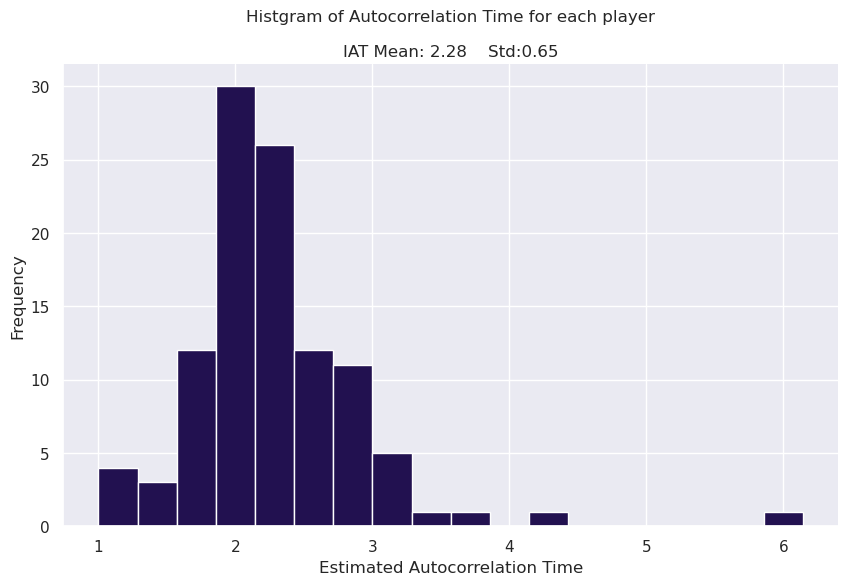

In [8]:
plt.figure(figsize=(10,6))
plt.hist(iats, bins=18)
mn = round(iats.mean(),2)
std = round(iats.std(), 2)
plt.title(f"Histgram of Autocorrelation Time for each player\n\n"+f"IAT Mean: {mn}    Std:{std}")
plt.xlabel("Estimated Autocorrelation Time")
plt.ylabel("Frequency")
#plt.savefig("hist_autocorr_time.png")

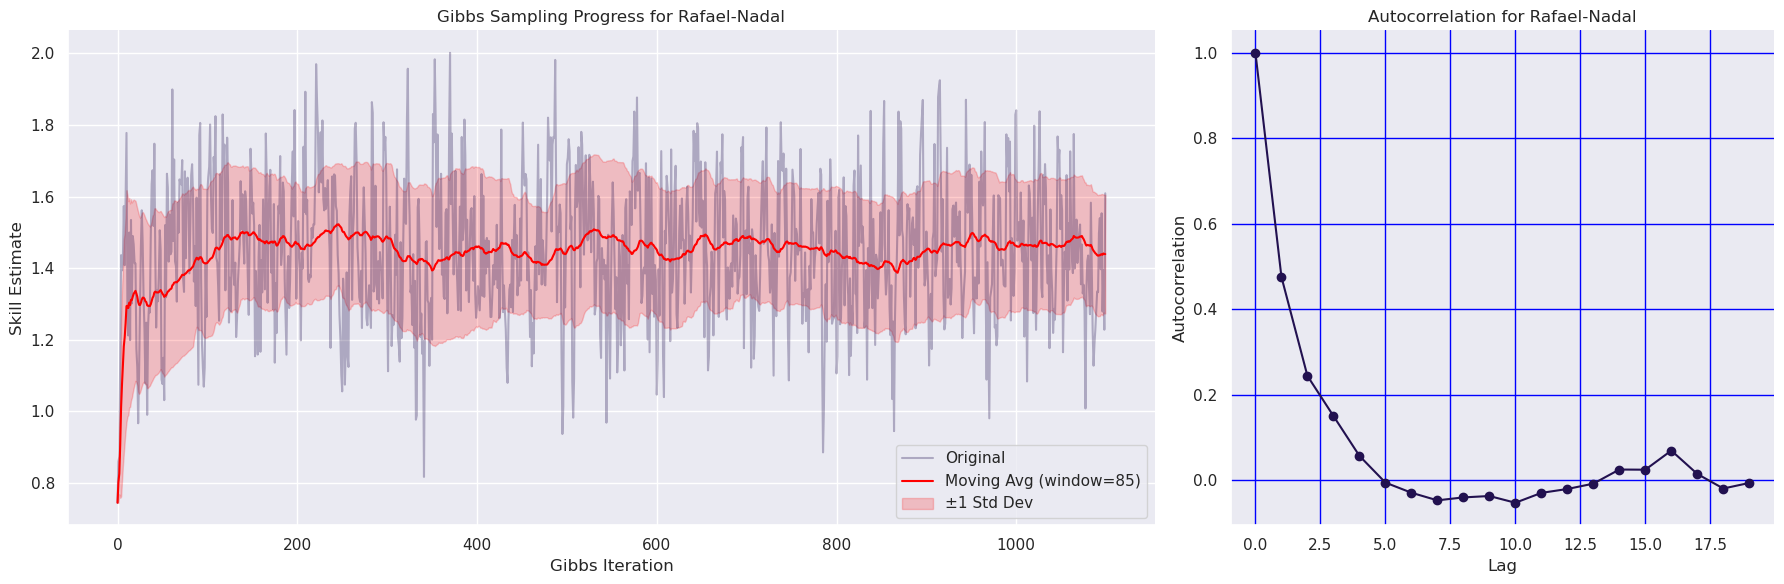

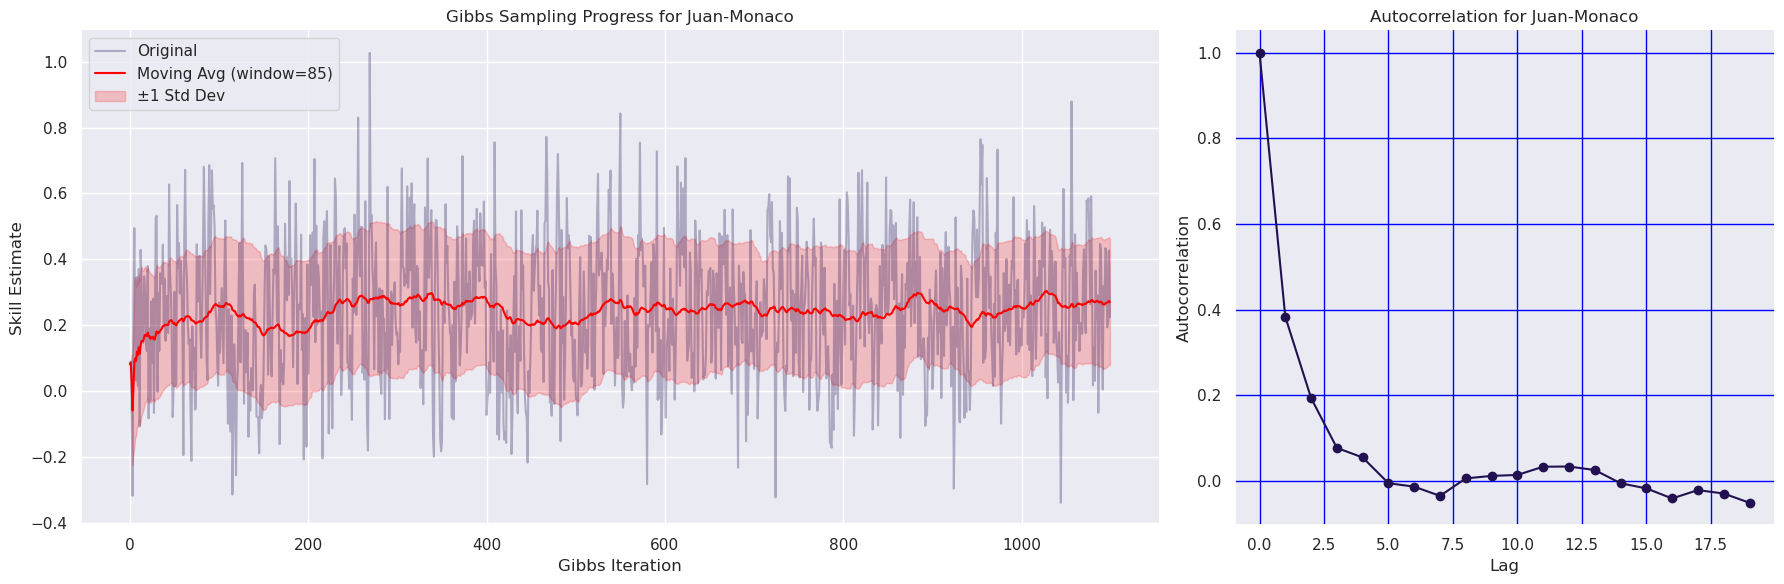

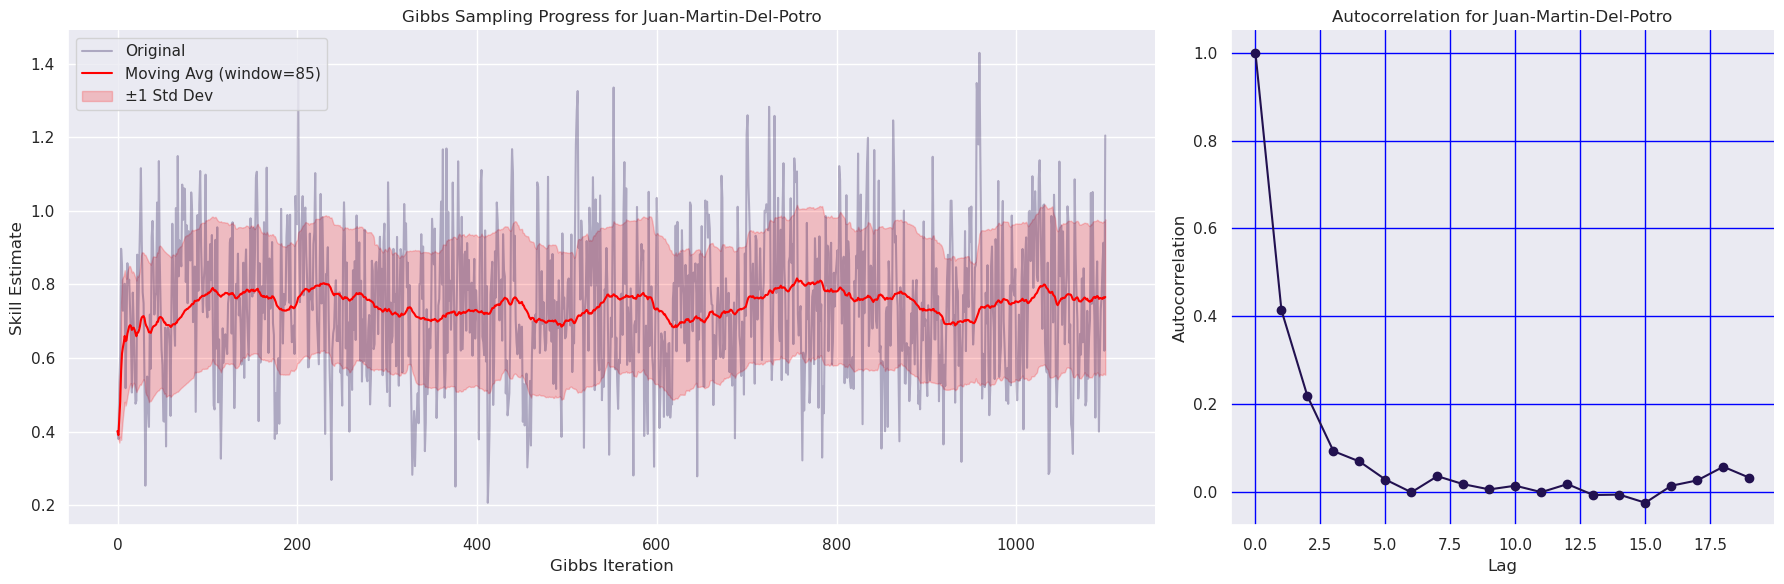

In [10]:
import matplotlib.gridspec as gridspec

# Define the moving average function with dynamic computation for n < 200
def dynamic_moving_average(data, window_size):
    means = []
    stds = []
    for i in range(len(data)):
        n = min(i + 1, window_size)  # Use up to the window size or available samples
        mean = np.mean(data[max(0, i - n + 1):i + 1])
        std = np.std(data[max(0, i - n + 1):i + 1])
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)

# Set moving average window size
window_size = 85

# Plot the Gibbs sampling progress and autocorrelation for the first 3 players
for player_id in range(3):  # First three players
    fig = plt.figure(figsize=(18, 6))
    spec = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Two subplots, 2:1 width ratio

    # Trajectory Plot
    ax0 = fig.add_subplot(spec[0])
    iterations = np.arange(skill_samples.shape[1])

    # Compute moving average and standard deviation
    ma_skill_samples, ma_std = dynamic_moving_average(skill_samples[player_id, :], window_size)

    # Original skill samples
    sns.lineplot(
        ax=ax0,
        x=iterations,
        y=skill_samples[player_id, :],
        label="Original",
        alpha=0.3
    )
    
    # Moving average
    sns.lineplot(
        ax=ax0,
        x=iterations,
        y=ma_skill_samples,
        label=f"Moving Avg (window={window_size})",
        color="red"
    )

    # Error bars
    ax0.fill_between(
        iterations,
        ma_skill_samples - ma_std,
        ma_skill_samples + ma_std,
        color="red",
        alpha=0.2,
        label="±1 Std Dev"
    )
    ax0.set_xlabel("Gibbs Iteration")
    ax0.set_ylabel("Skill Estimate")
    ax0.set_title(f"Gibbs Sampling Progress for {W[player_id][0]}")
    ax0.legend()

    # Autocorrelation Plot
    ax1 = fig.add_subplot(spec[1])
    autocor = np.zeros(20)
    for lag in range(20):
        autocor[lag] = pd.Series(skill_samples[player_id, :]).autocorr(lag=lag)
    
    ax1.plot(range(20), autocor, marker="o")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_title(f"Autocorrelation for {W[player_id][0]}")
    ax1.grid( which='major', color='b')
    # Adjust layout and show the plot
    plt.tight_layout()
    #plt.savefig(f"sample_ranking_id{player_id}.png")
    plt.show()

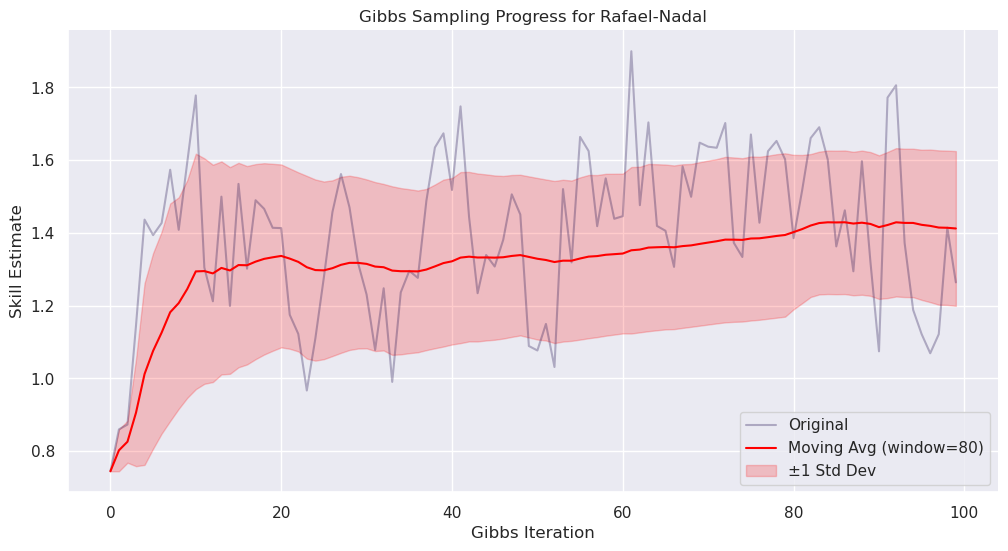

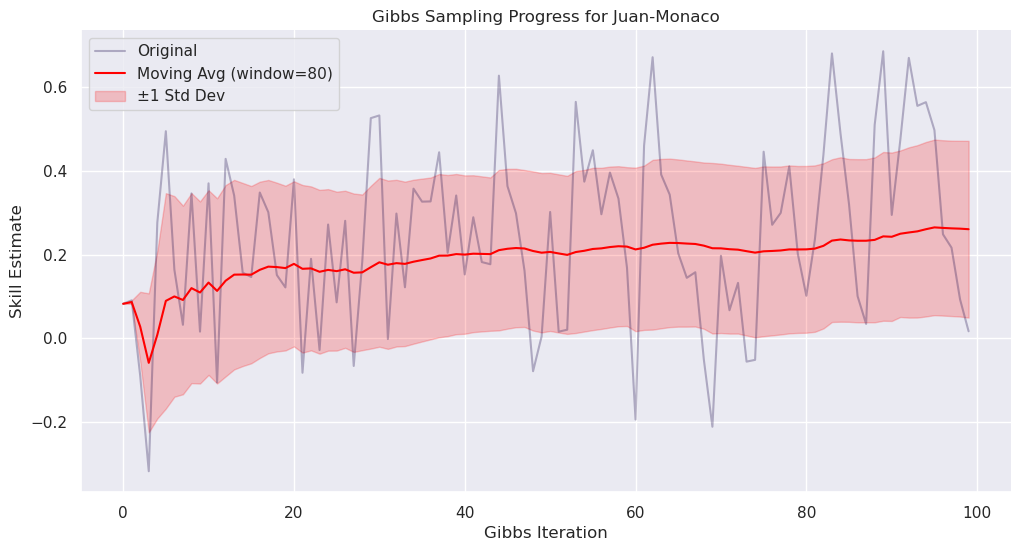

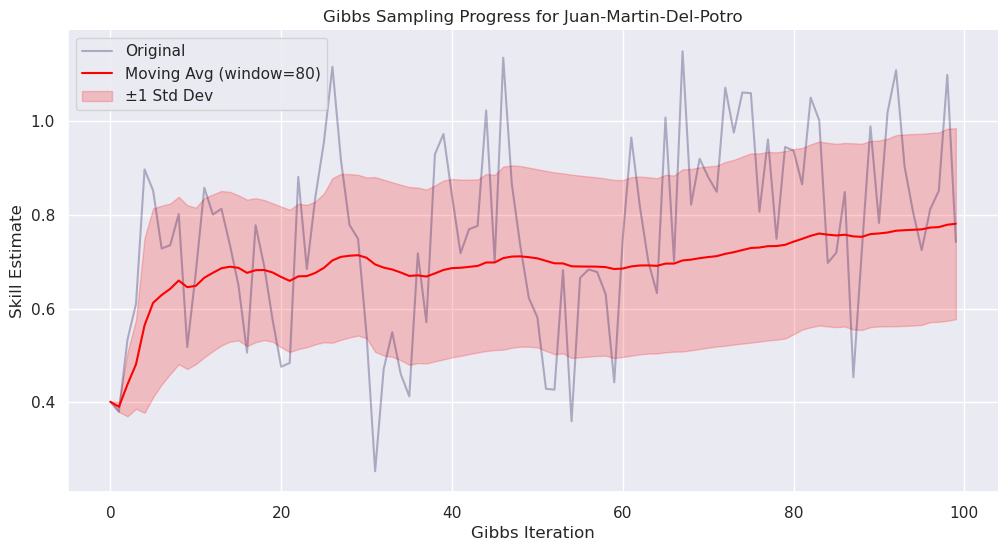

In [11]:
import pandas as pd
import numpy as np

# Define the moving average function with error handling for n < 200
def dynamic_moving_average(data, window_size):
    means = []
    stds = []
    for i in range(len(data)):
        n = min(i + 1, window_size)  # Use up to the window size or available samples
        mean = np.mean(data[max(0, i - n + 1):i + 1])
        std = np.std(data[max(0, i - n + 1):i + 1])
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)

# Set moving average window size
window_size = 80

# Plot the Gibbs sampling progress with moving average and error bars
for player_id in range(3):  # First three players
    plt.figure(figsize=(12, 6))
    
    # Compute moving average and standard deviation
    ma_skill_samples, ma_std = dynamic_moving_average(skill_samples[player_id, :], window_size)
    
    # Plot original skill samples
    sns.lineplot(
        x=iterations[:100],
        y=skill_samples[player_id, :100],
        label="Original",
        alpha=0.3,  # Make the original plot more transparent
    )
    
    # Plot moving average
    sns.lineplot(
        x=iterations[:100],
        y=ma_skill_samples[:100],
        label=f"Moving Avg (window={window_size})",
        color="red"
    )
    
    # Add error bars
    plt.fill_between(
        iterations[:100],
        (ma_skill_samples - ma_std)[:100],
        (ma_skill_samples + ma_std)[:100],
        color="red",
        alpha=0.2,
        label="±1 Std Dev"
    )
    
    # Add labels and title
    plt.xlabel("Gibbs Iteration")
    plt.ylabel("Skill Estimate")
    plt.title(f"Gibbs Sampling Progress for {W[player_id][0]}")
    plt.legend()
    #plt.savefig(f"task_a_gibbs_{W[player_id][0]}")



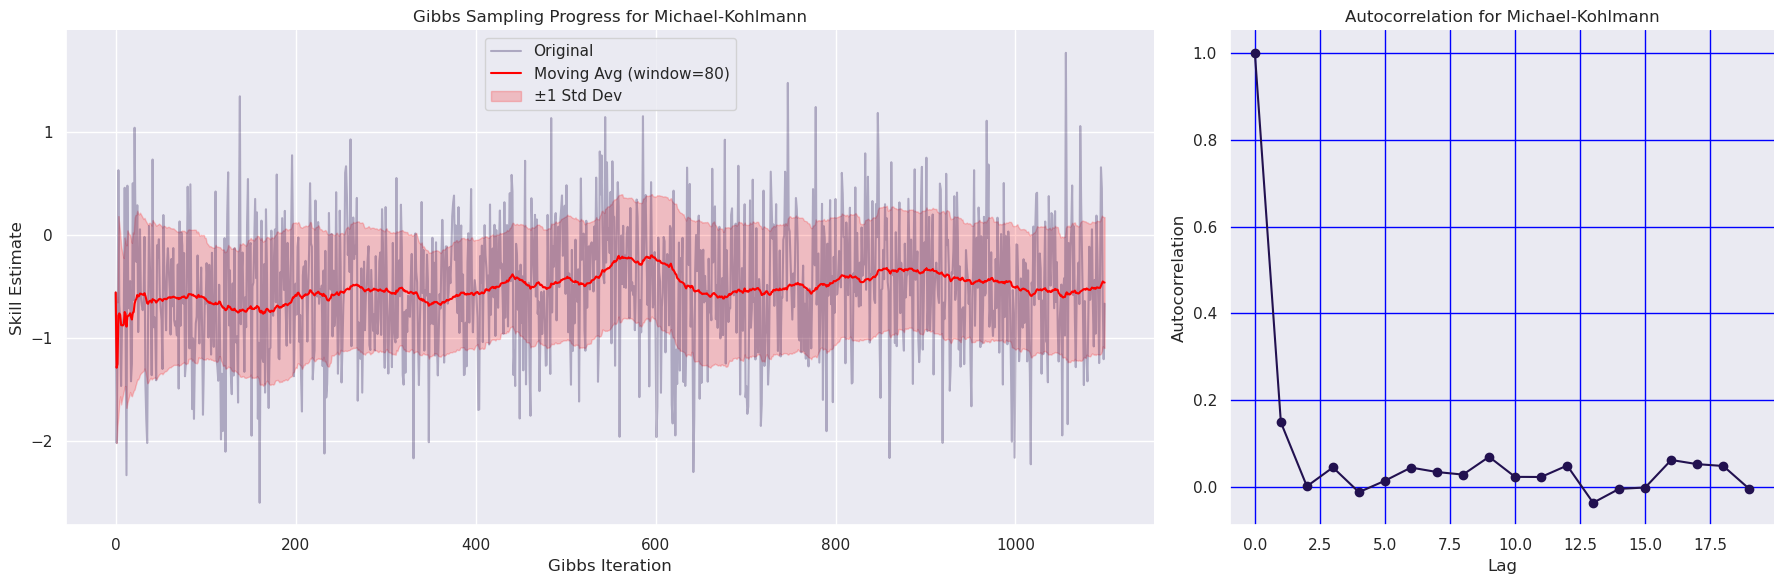

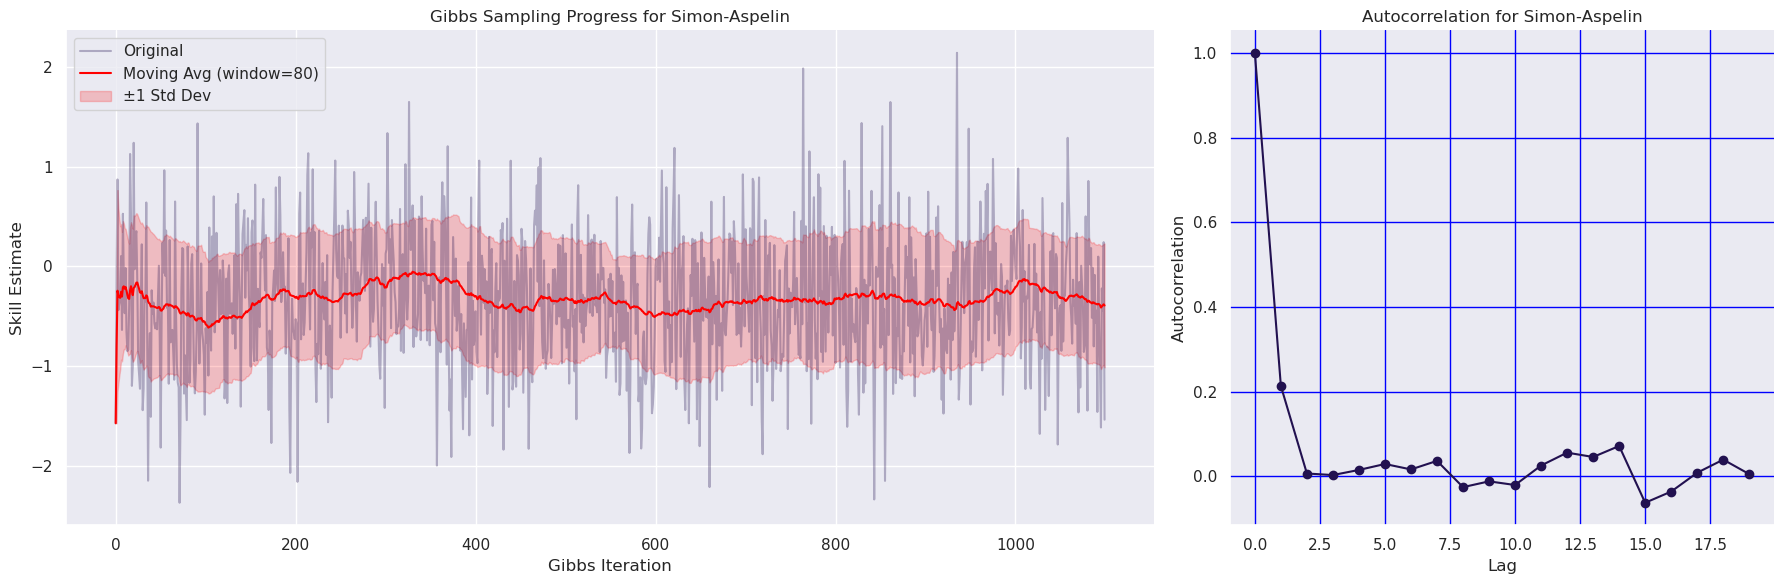

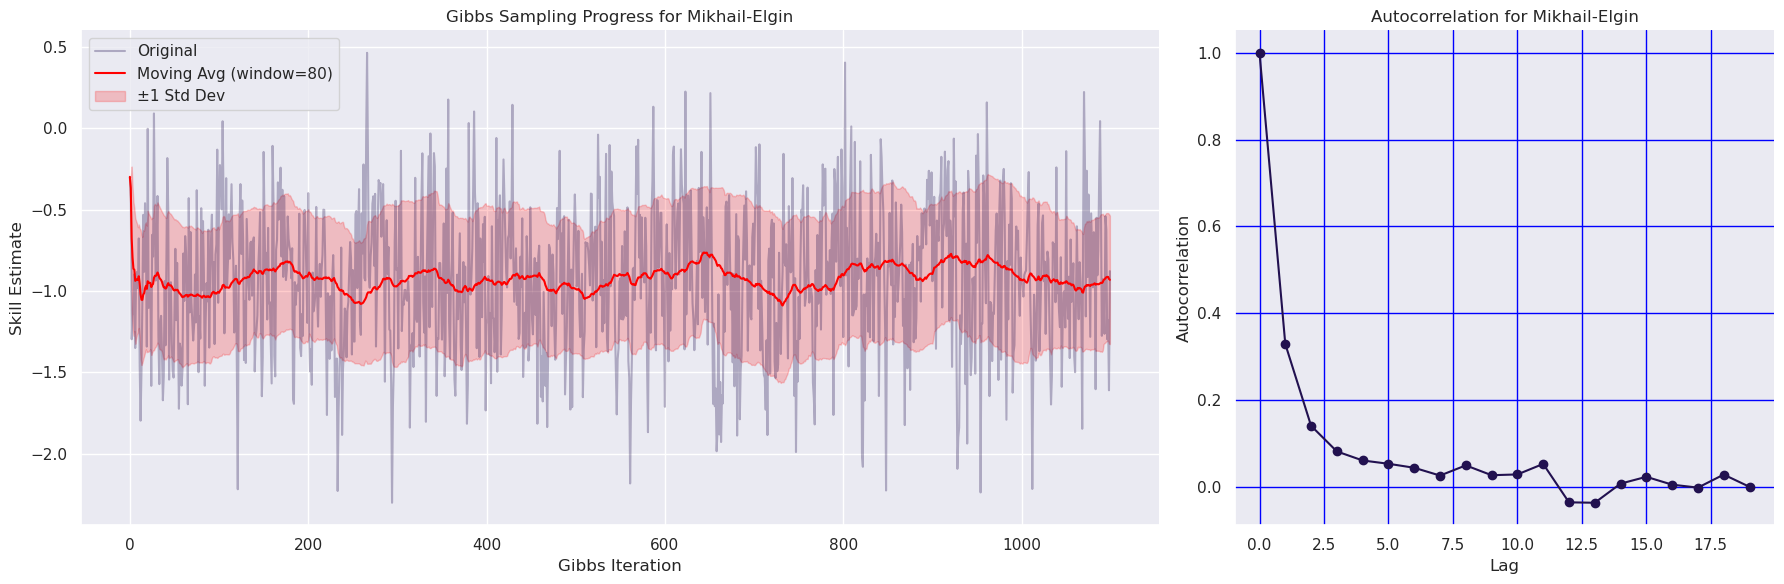

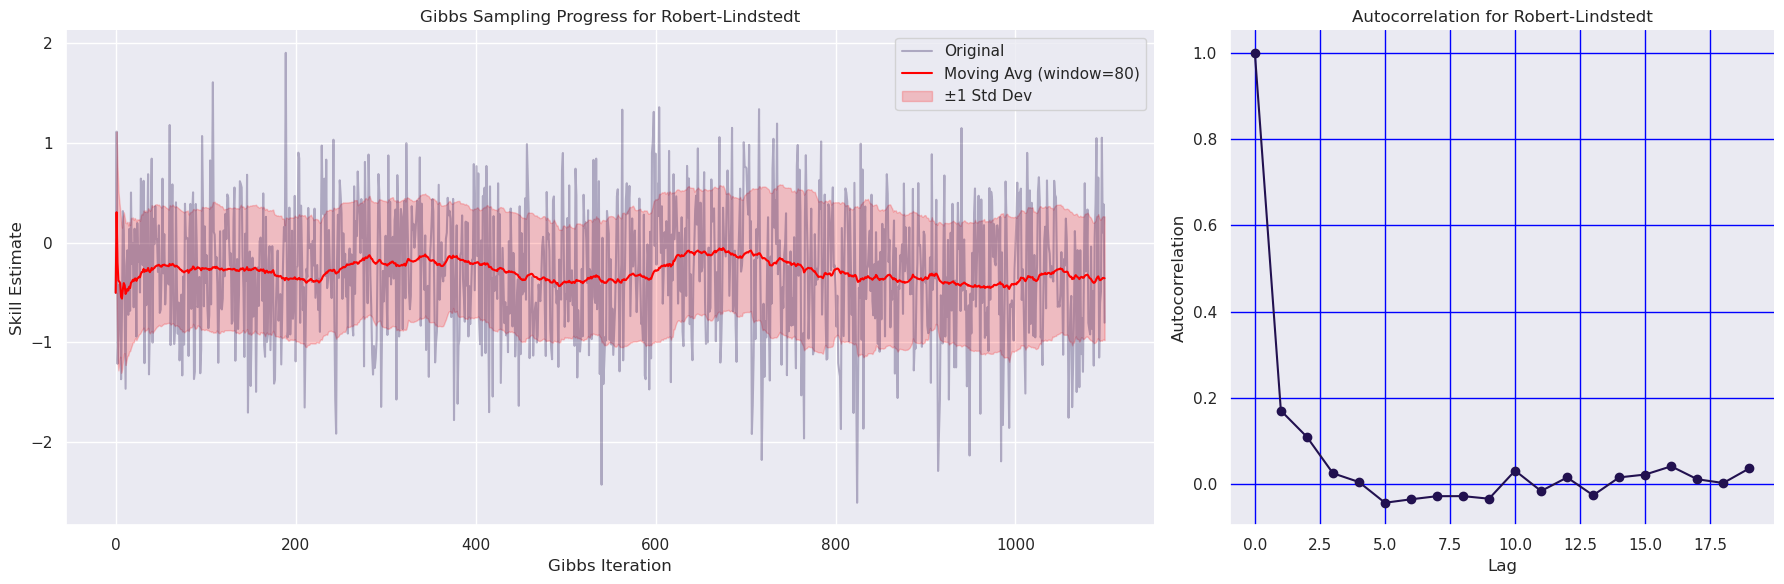

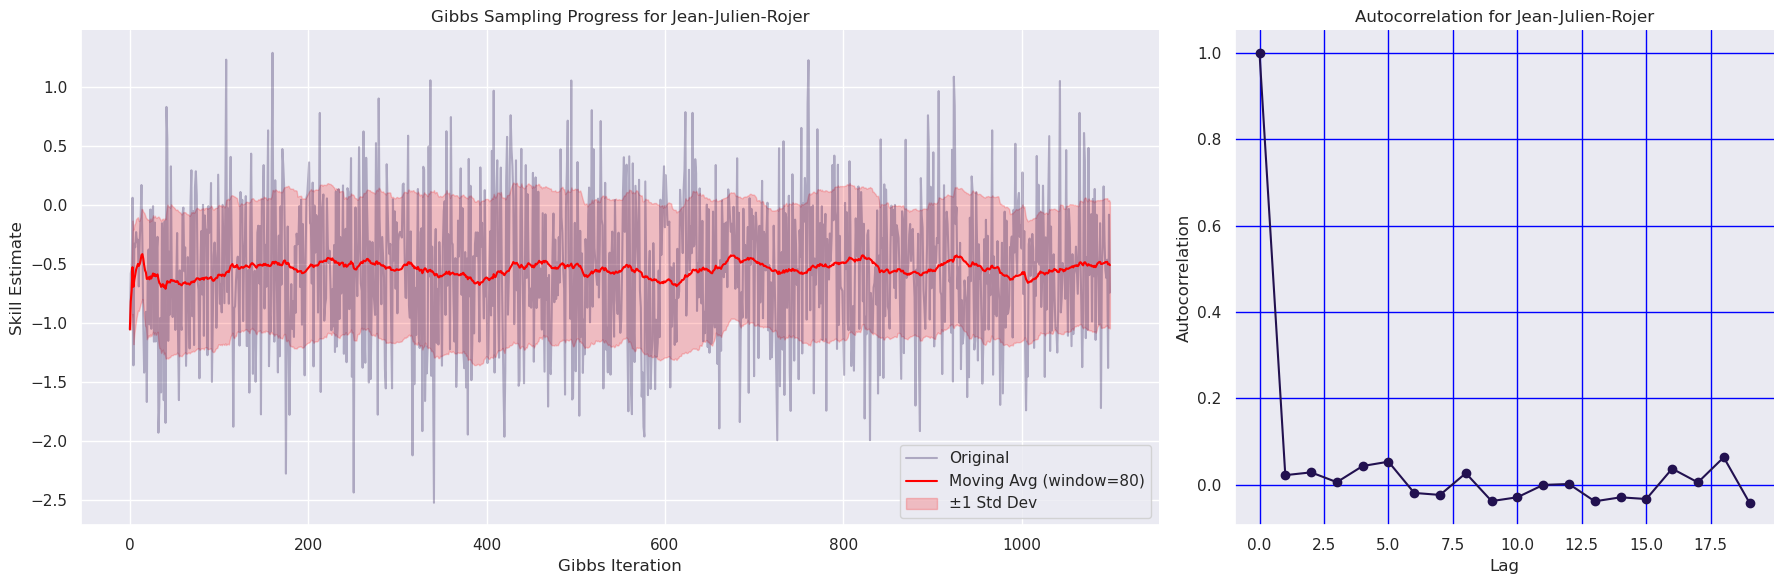

In [12]:
for player_id in range(M-5, M):
    fig = plt.figure(figsize=(18, 6))
    spec = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Two subplots, 2:1 width ratio

    # Trajectory Plot
    ax0 = fig.add_subplot(spec[0])
    iterations = np.arange(skill_samples.shape[1])

    # Compute moving average and standard deviation
    ma_skill_samples, ma_std = dynamic_moving_average(skill_samples[player_id, :], window_size)

    # Original skill samples
    sns.lineplot(
        ax=ax0,
        x=iterations,
        y=skill_samples[player_id, :],
        label="Original",
        alpha=0.3
    )
    
    # Moving average
    sns.lineplot(
        ax=ax0,
        x=iterations,
        y=ma_skill_samples,
        label=f"Moving Avg (window={window_size})",
        color="red"
    )

    # Error bars
    ax0.fill_between(
        iterations,
        ma_skill_samples - ma_std,
        ma_skill_samples + ma_std,
        color="red",
        alpha=0.2,
        label="±1 Std Dev"
    )
    ax0.set_xlabel("Gibbs Iteration")
    ax0.set_ylabel("Skill Estimate")
    ax0.set_title(f"Gibbs Sampling Progress for {W[player_id][0]}")
    ax0.legend()

    # Autocorrelation Plot
    ax1 = fig.add_subplot(spec[1])
    autocor = np.zeros(20)
    for lag in range(20):
        autocor[lag] = pd.Series(skill_samples[player_id, :]).autocorr(lag=lag)
    
    ax1.plot(range(20), autocor, marker="o")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_title(f"Autocorrelation for {W[player_id][0]}")
    ax1.grid(which='major', color='b')
    # Adjust layout and show the plot
    plt.tight_layout()
    #plt.savefig(f"sample_ranking_id{player_id}.png")
    plt.show()

## MCMC Burn-in

## Gelman-Rubin Statistic for MCMC Termination

To terminate a MCMC sampler, we need to set the threshold for the burn-in phase. 
One way to do this is to use the Gelman-Rubin statistic. The Gelman-Rubin statistic compares the variance between chains to the variance within chains. If the chains have converged, the variance between chains should be similar to the variance within chains. The Gelman-Rubin statistic is defined as: R = sqrt(V / W), where V is the variance between chains and W is the variance within chains.

In [13]:

def sample_seeds(num_experiments:int):
    np.random.seed(0)
    return np.random.randint(0, 2**32 - 1, size=num_experiments)

def gelman_rubin(x, return_var=False):
    """ Returns estimate of R for a set of traces.

    The Gelman-Rubin diagnostic tests for lack of convergence by comparing
    the variance between multiple chains to the variance within each chain.
    If convergence has been achieved, the between-chain and within-chain
    variances should be identical. To be most effective in detecting evidence
    for nonconvergence, each chain should have been initialized to starting
    values that are dispersed relative to the target distribution.

    Parameters
    ----------
    x : array-like
      An array containing the 2 or more traces of a stochastic parameter. That is, an array of dimension m x n x k, where m is the number of traces, n the number of samples, and k the dimension of the stochastic.
      
    return_var : bool
      Flag for returning the marginal posterior variance instead of R-hat (defaults of False).

    Returns
    -------
    Rhat : float
      Return the potential scale reduction factor, :math:`\hat{R}`
    -----

    The diagnostic is computed by:

      .. math:: \hat{R} = \sqrt{\frac{\hat{V}}{W}}

    where :math:`W` is the within-chain variance and :math:`\hat{V}` is
    the posterior variance estimate for the pooled traces. This is the
    potential scale reduction factor, which converges to unity when each
    of the traces is a sample from the target posterior. Values greater
    than one indicate that one or more chains have not yet converged.
    References
    ----------
    Brooks and Gelman (1998)
    Gelman and Rubin (1992)"""

    if np.shape(x) < (2,):
        raise ValueError(
            'Gelman-Rubin diagnostic requires multiple chains of the same length.')

    try:
        m, n = np.shape(x)
    except ValueError:
        return [gelman_rubin(np.transpose(y)) for y in np.transpose(x)]

    # Calculate between-chain variance
    B_over_n = np.sum((np.mean(x, 1) - np.mean(x)) ** 2) / (m - 1)

    # Calculate within-chain variances
    W = np.sum(
        [(x[i] - xbar) ** 2 for i,
         xbar in enumerate(np.mean(x,
                                   1))]) / (m * (n - 1))

    # (over) estimate of variance
    s2 = W * (n - 1) / n + B_over_n
    
    if return_var:
        return s2

    # Pooled posterior variance estimate
    V = s2 + B_over_n / m

    # Calculate PSRF
    R = V / W

    return np.sqrt(R)


In [15]:
#number of seeds
nseeds = 10
seeds = sample_seeds(nseeds)
# number of iterations
num_iters = 1_100
# perform gibbs sampling, skill samples is an num_players x num_samples array
ensemble = np.zeros((nseeds, M, num_iters))
print(ensemble.shape)
from tqdm import tqdm
for i in tqdm(range(nseeds)):
    ensemble[i,:,:] = gibbs_sample(G, M, num_iters)


(10, 107, 1100)


100%|██████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.05s/it]


Perform a mock experiment in R^ metric computation. This ensures we are ok with the time limits.

In [17]:
metrics_gelman = {}
for player_id in range(ensemble.shape[1]):
    print(F"______________{W[player_id][0]}")
    metrics_gelman[W[player_id][0]] = gelman_rubin(ensemble[:, player_id, :])
    print(metrics_gelman[W[player_id][0]])


______________Rafael-Nadal
1.0015802164534
______________Juan-Monaco
1.0008875082145676
______________Juan-Martin-Del-Potro
1.00114840351743
______________Mardy-Fish
1.001962900351572
______________Roger-Federer
1.0016873625359375
______________Jo-Wilfried-Tsonga
1.0002906117335626
______________Guillermo-Garcia-Lopez
1.0014391570086003
______________Florian-Mayer
1.0004277115447164
______________Milos-Raonic
1.0004653207691507
______________Santiago-Giraldo
1.0008648983689004
______________Andy-Murray
1.0006790301905655
______________Richard-Gasquet
1.0008647534572055
______________David-Nalbandian
1.0007316126219956
______________Gilles-Muller
1.000841062351787
______________Andy-Roddick
1.0023944670268294
______________Novak-Djokovic
1.0008986001837674
______________Fernando-Verdasco
1.0004513141376254
______________Ivan-Dodig
1.0008323268449022
______________Ryan-Sweeting
1.0001394179544627
______________Radek-Stepanek
0.9998246762906501
______________John-Isner
1.0014430266624208


In [ ]:
gelman_td = {}
for player_id in range(M):
    gelman_td[W[player_id][0]] = np.zeros((N-2))
    for t in range(2, N):
        gelman_td[W[player_id][0]][t-2] = gelman_rubin(ensemble[:, player_id, :t]) 

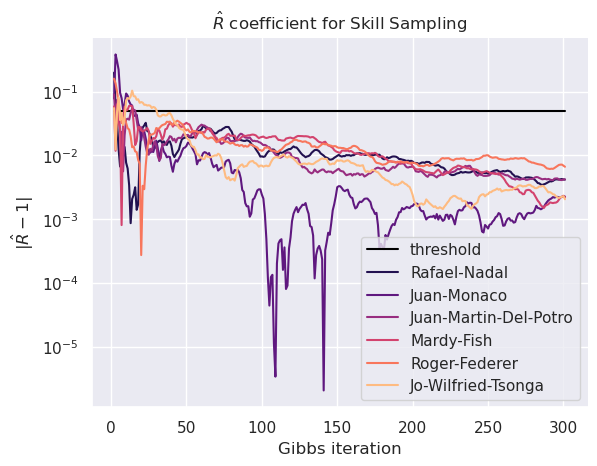

In [22]:
THRESHOLD =  5E-2
plt.figsize=(8, 6)
plt.plot(
    range(2, 300 + 2), THRESHOLD * np.ones_like(gelman_td[W[3][0]])[:300], 
    c = "black", 
    label="threshold"
)

for player_id in range(6):
    plt.plot(
        range(2, 300 + 2), 
        np.abs(gelman_td[W[player_id][0]] - 1.0)[:300] , 
        label=f"{W[player_id][0]}"
    )
plt.yscale('log')
plt.xlabel("Gibbs iteration")
plt.ylabel("$|\hat{R} - 1|$")
plt.legend()
plt.title("$\hat{R}$ coefficient for Skill Sampling")
plt.show()

In [27]:
THRESHOLD = 1E-1
burn_time = 0
burn_times={}
for player, trace in gelman_td.items():
    res = np.abs(np.abs(trace - 1.0) - THRESHOLD)
    curr = 2 + np.argmin(res)
    burn_times[player] = curr
    burn_time = max(burn_time, curr)
burn_np = np.array(list(burn_times.values()))
print(f"BURN TIME: {burn_time}")

BURN TIME: 39


Text(0, 0.5, 'Frequency')

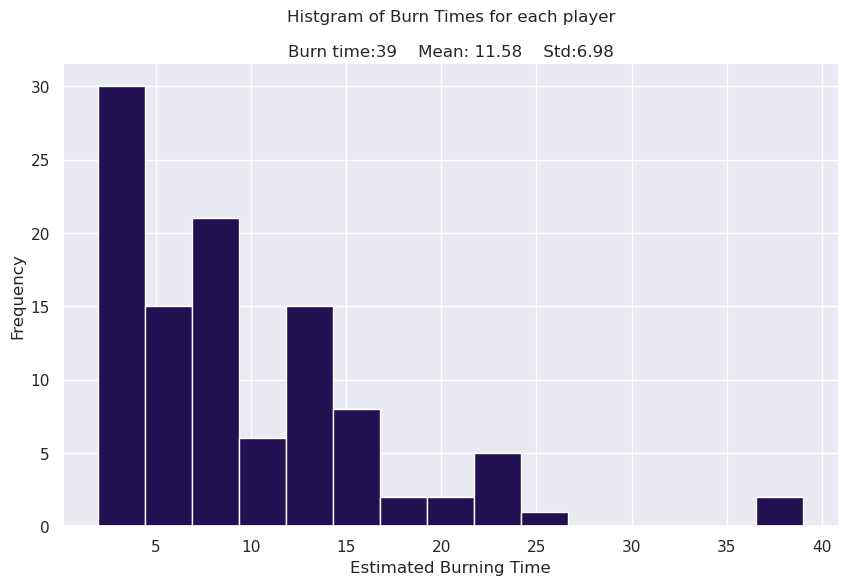

In [28]:
from scipy.stats import mode
plt.figure(figsize=(10,6))
plt.hist(burn_times.values(), bins=15)
mn = 2 + round(burn_np.mean(),2)
md = 2 + round(mode(burn_np,axis=None, keepdims=False).mode,2)
std = round(burn_np.std(), 2)
plt.title(f"Histgram of Burn Times for each player\n\n"+f"Burn time:{burn_time}    Mean: {mn}    Std:{std}")
burn_np = np.array(list(burn_times.values()))
plt.xlabel("Estimated Burning Time")
plt.ylabel("Frequency")
#plt.savefig("hist_burn_time.png")

## Burn and Thin

In [59]:
thin_factor = 10
burn_factor = 150
# number of iterations
num_samples_to_generate = 150
num_iters = burn_factor + num_samples_to_generate * thin_factor
# perform gibbs sampling, skill samples is an num_players x num_samples array
np.random.seed(0)
iid_samples = gibbs_sample(G, M, num_iters)[:, burn_factor::thin_factor]

100%|██████████████████████████████████████████████████████| 1650/1650 [00:31<00:00, 52.90it/s]


(150,)


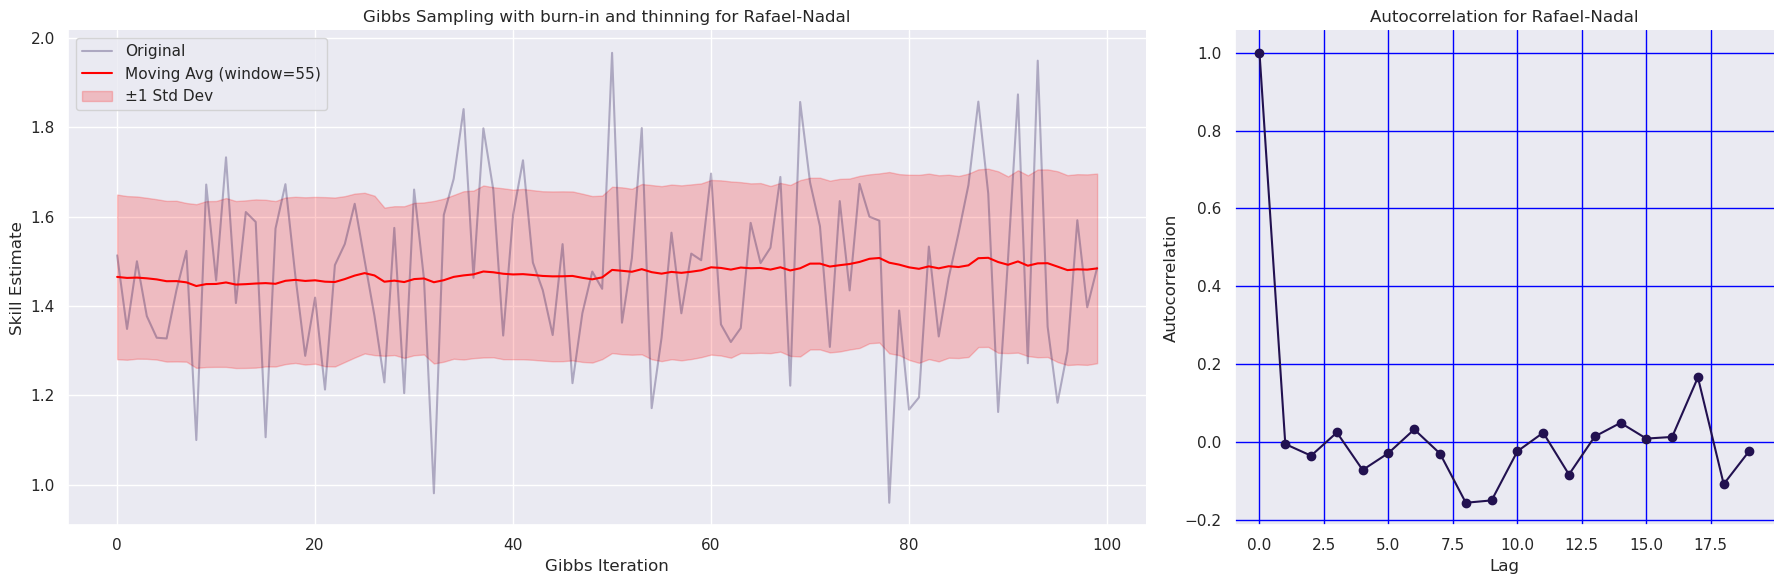

(150,)


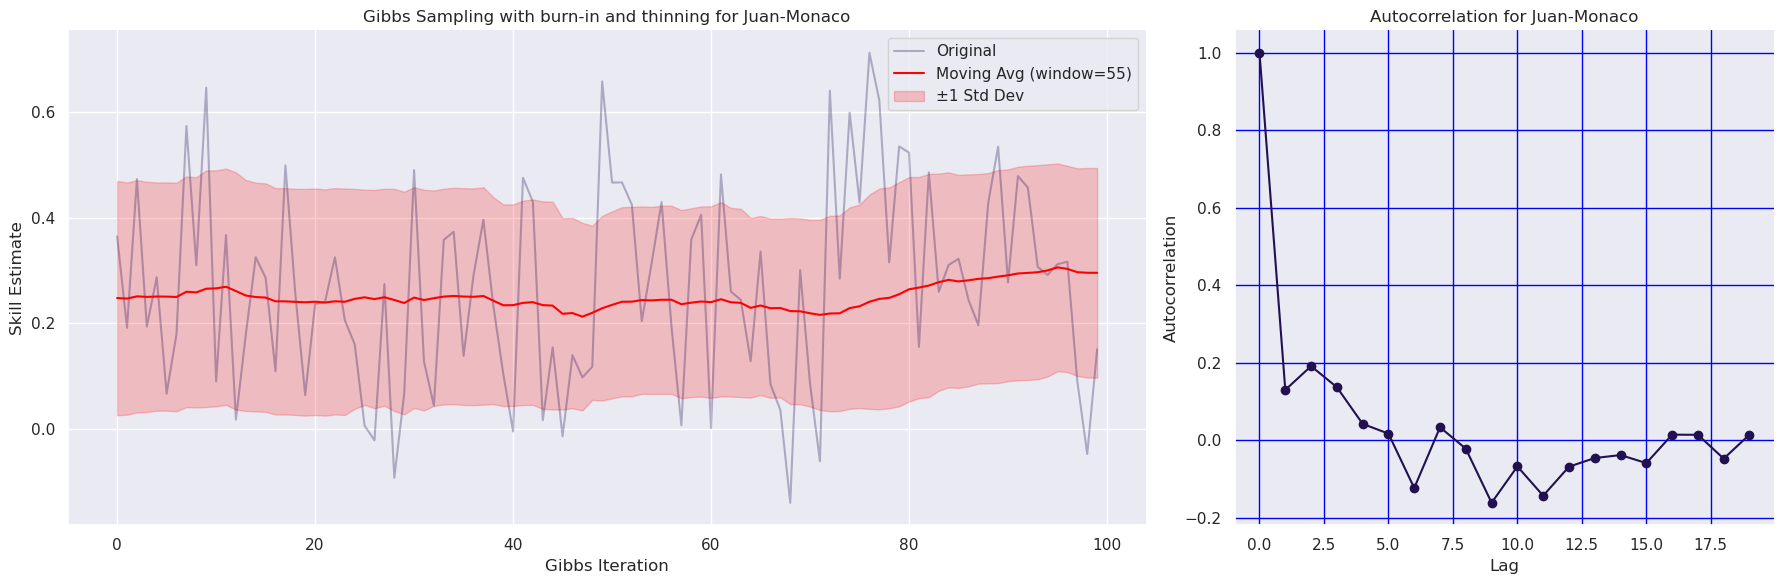

(150,)


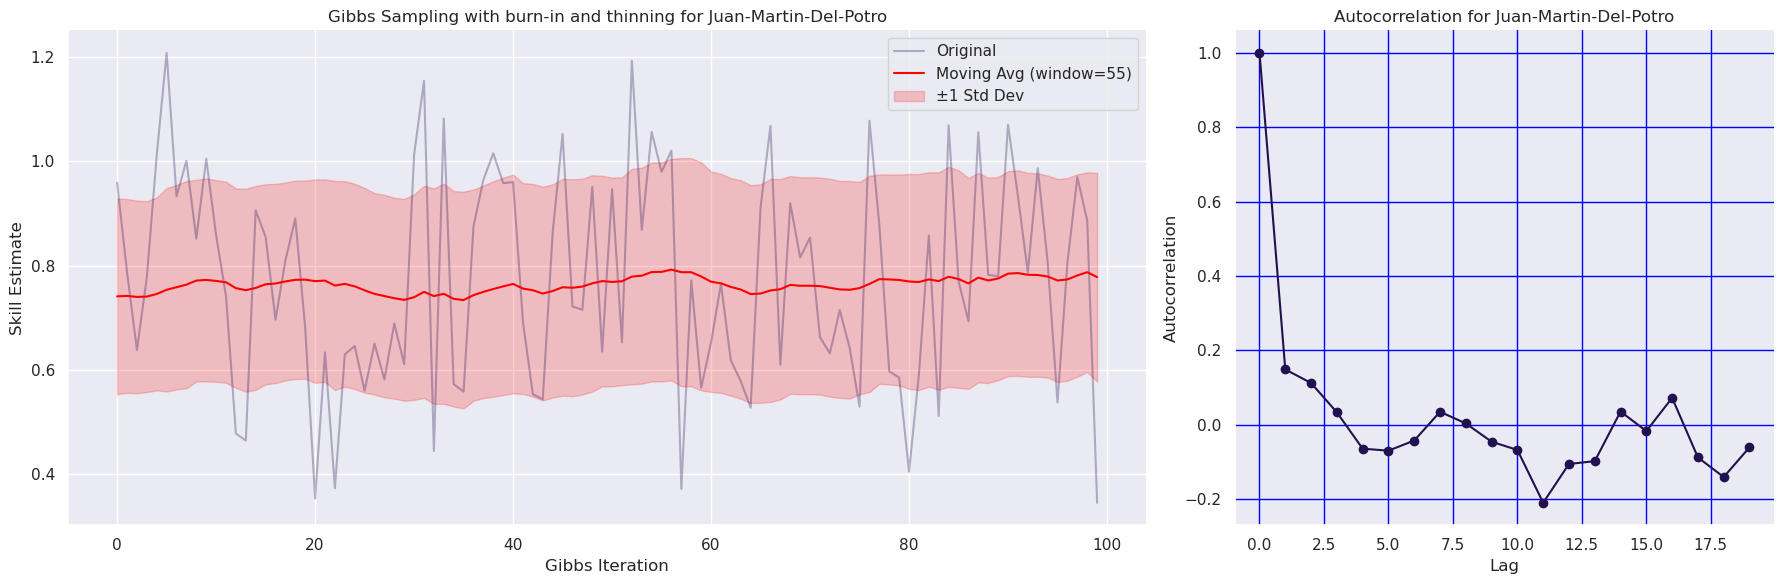

In [68]:
# Plot the Gibbs sampling progress and autocorrelation for the first 3 players
window_size = 55
for player_id in range(3):  # First three players
    fig = plt.figure(figsize=(18, 6))
    spec = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Two subplots, 2:1 width ratio

    # Trajectory Plot
    ax0 = fig.add_subplot(spec[0])
    iterations = np.arange(iid_samples.shape[1])

    # Compute moving average and standard deviation
    ma_skill_samples, ma_std = dynamic_moving_average(iid_samples[player_id, :], window_size)
    print(ma_skill_samples.shape)
    # Original skill samples
    sns.lineplot(
        ax=ax0,
        x=iterations[:-50],
        y=iid_samples[player_id, 50:],
        label="Original",
        alpha=0.3
    )
    
    # Moving average
    sns.lineplot(
        ax=ax0,
        x=iterations[:-50],
        y=ma_skill_samples[50:],
        label=f"Moving Avg (window={window_size})",
        color="red"
    )

    # Error bars
    ax0.fill_between(
        iterations[:-50],
        ma_skill_samples[50:] - ma_std[50:],
        ma_skill_samples[50:] + ma_std[50:],
        color="red",
        alpha=0.2,
        label="±1 Std Dev"
    )
    ax0.set_xlabel("Gibbs Iteration")
    ax0.set_ylabel("Skill Estimate")
    ax0.set_title(f"Gibbs Sampling with burn-in and thinning for {W[player_id][0]}")
    ax0.legend()

    # Autocorrelation Plot
    ax1 = fig.add_subplot(spec[1])
    autocor = np.zeros(20)
    for lag in range(20):
        autocor[lag] = pd.Series(iid_samples[player_id, :]).autocorr(lag=lag)
    
    ax1.plot(range(20), autocor, marker="o")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_title(f"Autocorrelation for {W[player_id][0]}")
    ax1.grid( which='major', color='b')
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig(f"iid_sample_ranking_id{player_id}.png")
    plt.show()

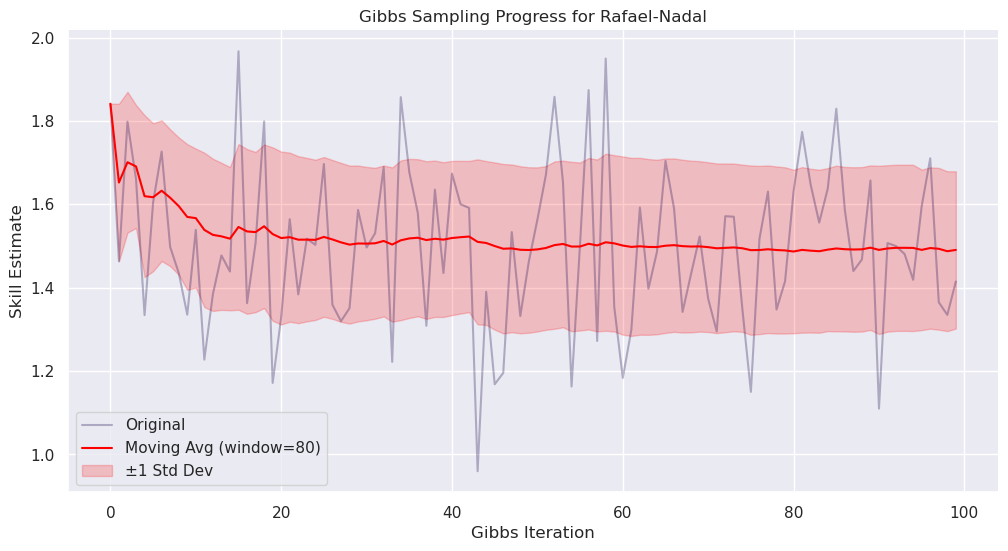

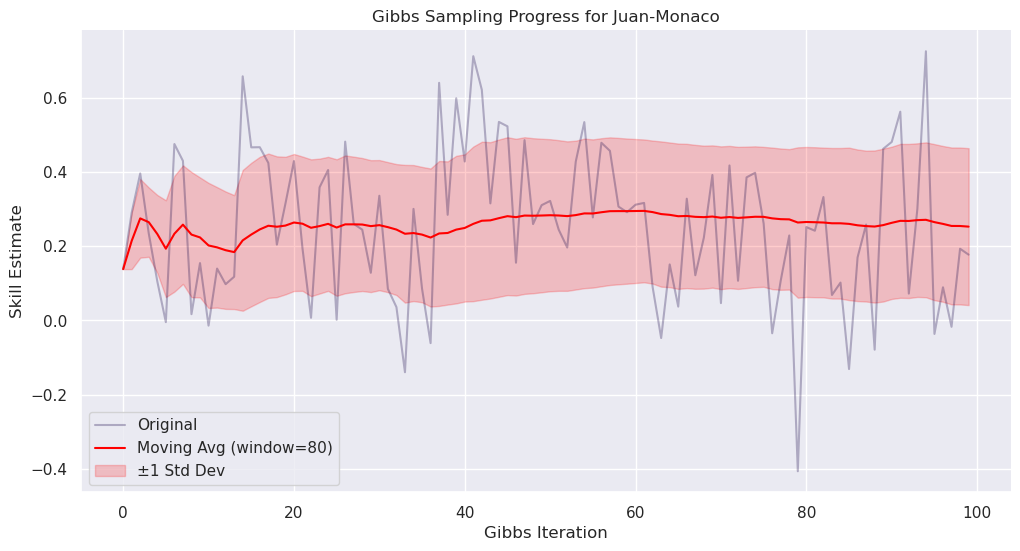

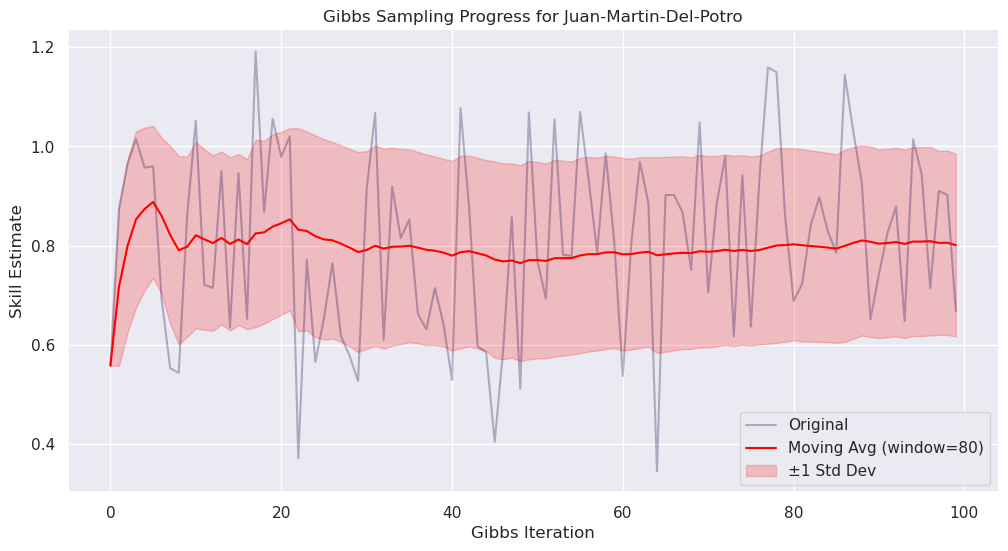

In [34]:

# Plot the Gibbs sampling progress with moving average and error bars
for player_id in range(3):  # First three players
    plt.figure(figsize=(12, 6))
    
    # Compute moving average and standard deviation
    ma_skill_samples, ma_std = dynamic_moving_average(iid_samples[player_id, :], window_size)
    
    # Plot original skill samples
    sns.lineplot(
        x=iterations[:100],
        y=iid_samples[player_id, :100],
        label="Original",
        alpha=0.3,  # Make the original plot more transparent
    )
    
    # Plot moving average
    sns.lineplot(
        x=iterations[:100],
        y=ma_skill_samples[:100],
        label=f"Moving Avg (window={window_size})",
        color="red"
    )
    
    # Add error bars
    plt.fill_between(
        iterations[:100],
        (ma_skill_samples - ma_std)[:100],
        (ma_skill_samples + ma_std)[:100],
        color="red",
        alpha=0.2,
        label="±1 Std Dev"
    )
    
    # Add labels and title
    plt.xlabel("Gibbs Iteration")
    plt.ylabel("Skill Estimate")
    plt.title(f"Gibbs Sampling Progress for {W[player_id][0]}")
    plt.legend()
    #plt.savefig(f"task_a_iid_gibbs_{W[player_id][0]}")

# Task B

In [196]:
num_iters = 1_000
# run message passing algorithm, returns mean and precision for each player
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)

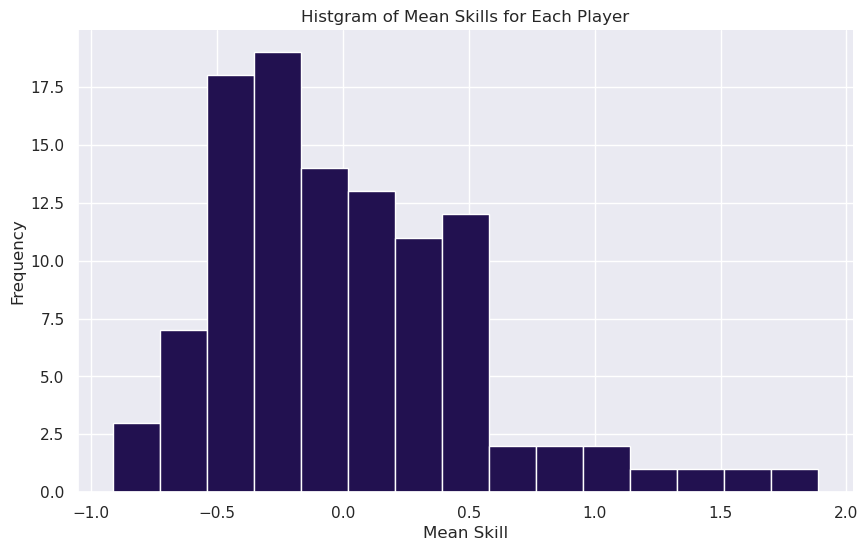

In [27]:
plt.figure(figsize=(10,6))
plt.hist(mean_player_skills, bins=15)
plt.title(f"Histgram of Mean Skills for Each Player")
plt.xlabel("Mean Skill")
plt.ylabel("Frequency")
plt.savefig("hist_skill_fgraph.png")

In [28]:
mean_player_skills.shape

(107,)

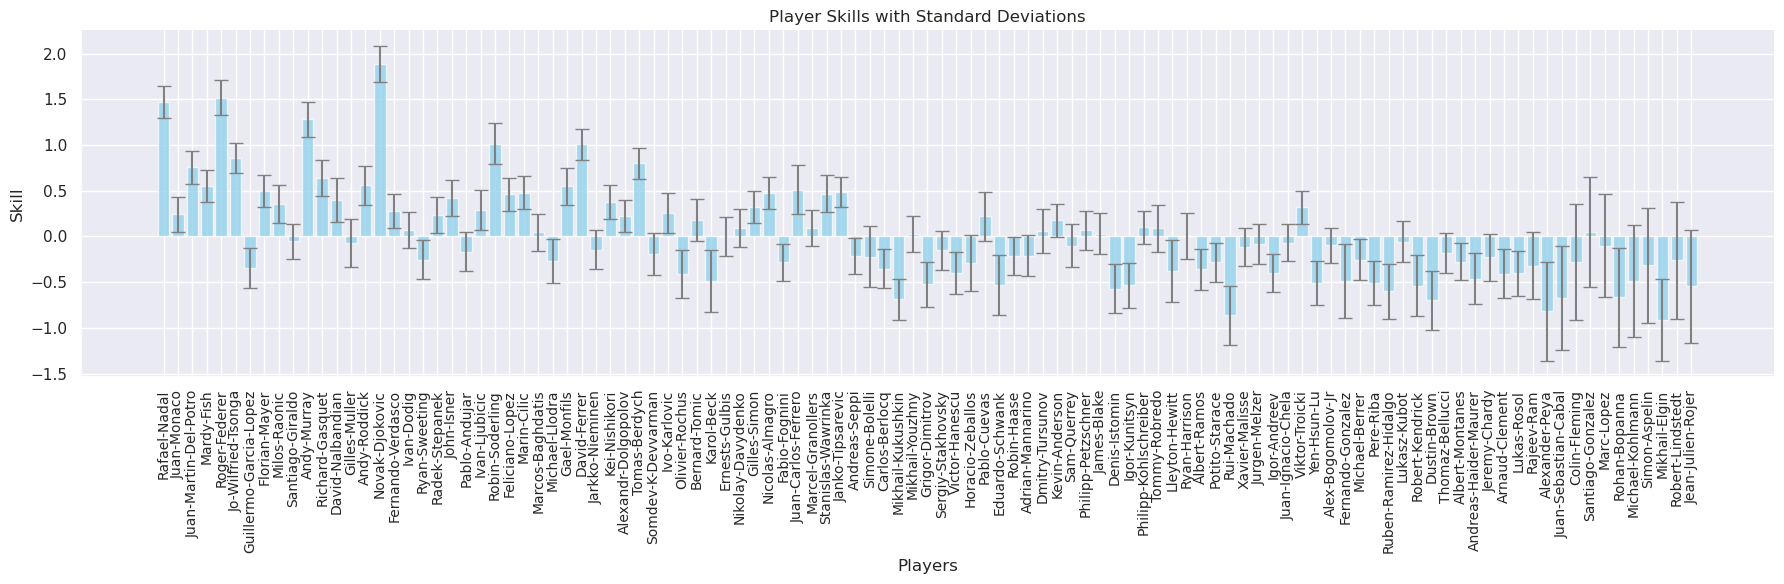

In [29]:
std_player_skills = 1 / np.sqrt(precision_player_skills)

# Extract player names
player_names = [W[i][0] for i in range(len(mean_player_skills))]

# Create the bar plot
plt.figure(figsize=(18, 6))
bars = plt.bar(
    player_names, 
    mean_player_skills, 
    yerr=std_player_skills, 
    capsize=5, 
    alpha=0.7, 
    color="skyblue", 
    error_kw={"ecolor": "gray", "elinewidth": 1.5}
)

# Enhance the plot
plt.xticks(rotation=90, fontsize=10, ha="center")
plt.xlabel("Players")
plt.ylabel("Skill")
plt.title("Player Skills with Standard Deviations")
plt.tight_layout()
plt.savefig("barplot_skills_with_std_90deg.png")
plt.show()

In [34]:
mean_skills_list, precision_skills_list = eprank_iter(G, M, num_iters)
mean_skills = np.stack(mean_skills_list, axis=0)
precision_skills = np.stack(precision_skills_list, axis=0)

In [36]:
std_skills = 1.0 / np.sqrt(precision_skills)
mean_skills.shape

(1000, 107)

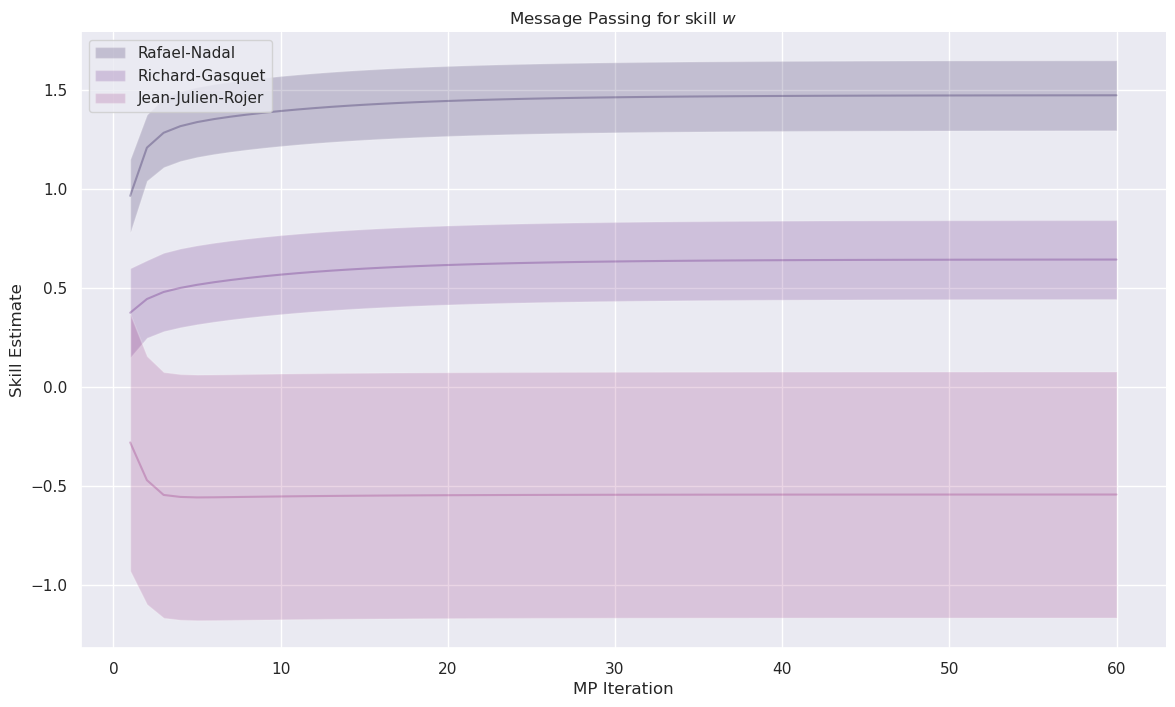

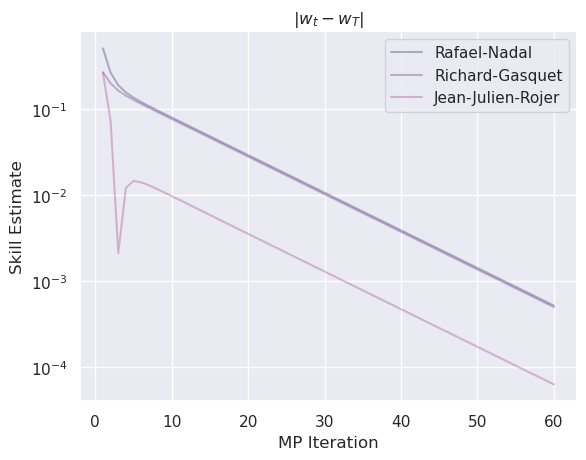

In [95]:
show_n_iter = 60

iterations = np.arange(show_n_iter+1)
plt.figure(figsize=(14, 8))
for pid in {-1, 0, 11}:  # First three players
    # Plot original skill samples
    sns.lineplot(
        x=iterations[1:],
        y=mean_skills[1: show_n_iter+1, pid],
        alpha=0.3,  # Make the original plot more transparent
    )
    
    # Add error bars
    plt.fill_between(
        iterations[1:],
        (mean_skills[1:show_n_iter+1,pid] - std_skills[1:show_n_iter+1,pid]),
        (mean_skills[1:show_n_iter+1,pid] + std_skills[1:show_n_iter+1,pid]),
        alpha=0.2,
        label=W[pid][0]
    )
plt.legend()
plt.xlabel("MP Iteration")
plt.ylabel("Skill Estimate")
plt.title(f"Message Passing for skill $w$")        
#plt.savefig(f"task_b_mp")
plt.show()

for pid in {-1, 0, 11}:  # First three players
    # Plot original skill samples
    sns.lineplot(
        x=iterations[1:],
        y=np.abs(mean_skills[1: show_n_iter+1, pid] - mean_skills[-1, pid]),
        alpha=0.3,  # Make the original plot more transparent
        label=W[pid][0]
    )
    
plt.legend()
plt.xlabel("MP Iteration")
plt.ylabel("Skill Estimate")
plt.yscale("log")
plt.title(f"$|w_t - w_T|$")        
plt.savefig(f"task_b_mp_error")
plt.show()

    

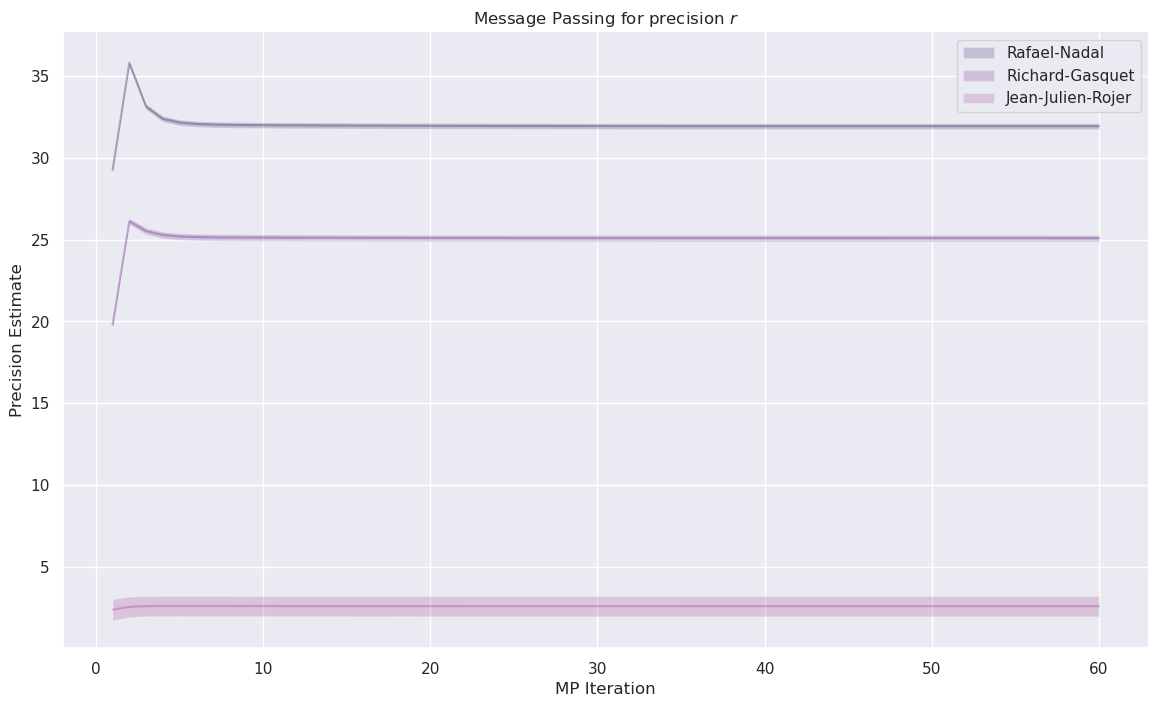

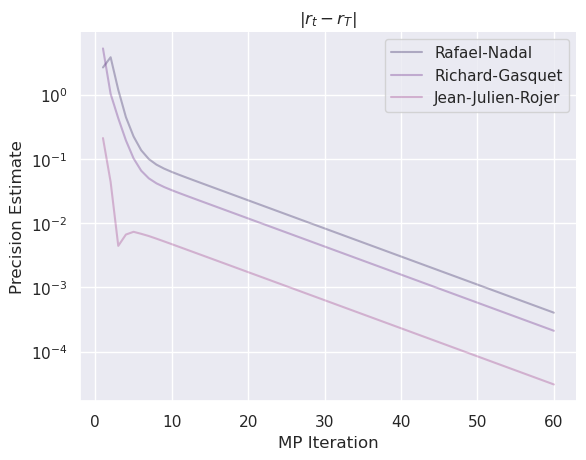

In [99]:
show_n_iter = 60

iterations = np.arange(show_n_iter+1)
plt.figure(figsize=(14, 8))
for pid in {-1, 0, 11}:  # First three players
    # Plot original skill samples
    sns.lineplot(
        x=iterations[1:],
        y=precision_skills[1: show_n_iter+1, pid],
        alpha=0.3,  # Make the original plot more transparent
    )
    
    # Add error bars
    plt.fill_between(
        iterations[1:],
        (precision_skills[1:show_n_iter+1,pid] - std_skills[1:show_n_iter+1,pid]),
        (precision_skills[1:show_n_iter+1,pid] + std_skills[1:show_n_iter+1,pid]),
        alpha=0.2,
        label=W[pid][0]
    )
plt.legend()
plt.xlabel("MP Iteration")
plt.ylabel("Precision Estimate")
plt.title(f"Message Passing for precision $r$")        
plt.savefig(f"task_b_mp_prec")
plt.show()

for pid in {-1, 0, 11}:  # First three players
    # Plot original skill samples
    sns.lineplot(
        x=iterations[1:],
        y=np.abs(precision_skills[1: show_n_iter+1, pid] - precision_skills[-1, pid]),
        alpha=0.3,  # Make the original plot more transparent
        label=W[pid][0]
    )
    
plt.legend()
plt.xlabel("MP Iteration")
plt.ylabel("Precision Estimate")
plt.yscale("log")
plt.title(f"$|r_t - r_T|$")        
plt.savefig(f"task_b_mp_prec_error")
plt.show()


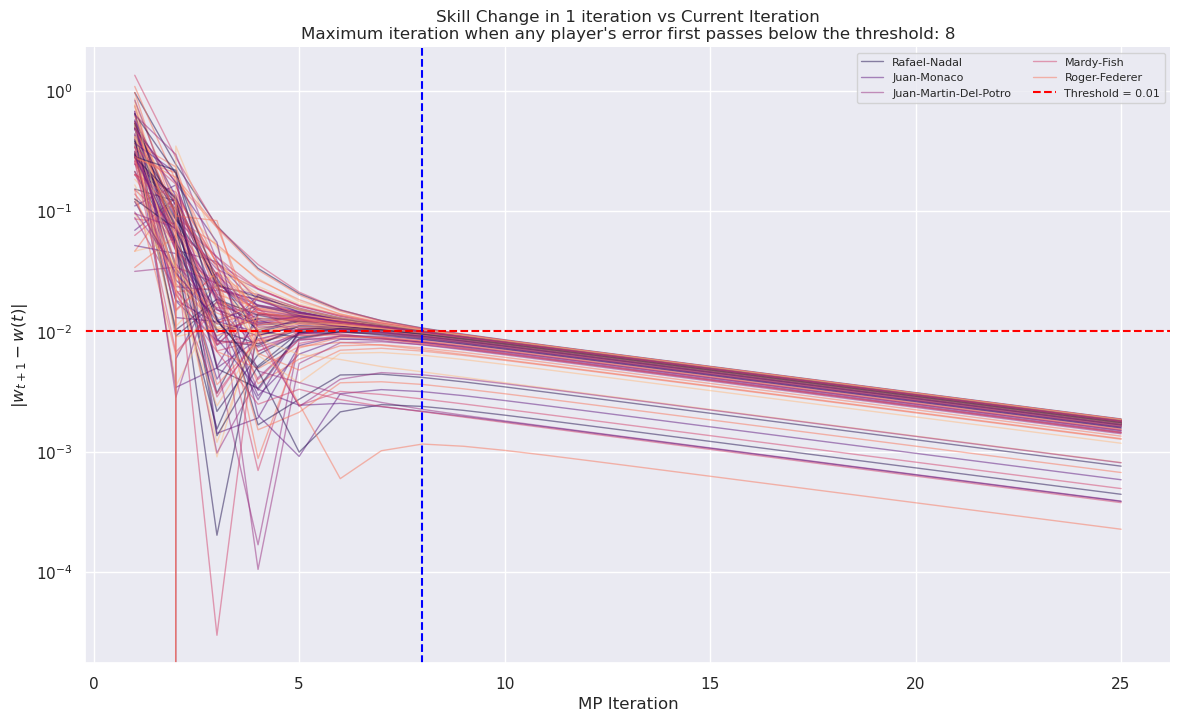

In [70]:
show_n_iter = 25
threshold = 0.01

# Compute the errors between consecutive iterations
errors = np.abs(mean_skills[1:] - mean_skills[:-1])  # Shape: (iterations-1, players)

# Find the iteration when each player's error first goes below the threshold
first_below_threshold = np.argmax(errors < threshold, axis=0)  # Returns the first "True" index for each player

# Mask players who never drop below the threshold within the given iterations
first_below_threshold[~np.any(errors < threshold, axis=0)] = -1  # Set to -1 if never below threshold

# Get the maximum iteration across all players where the threshold is first passed
max_time_below_threshold = np.max(first_below_threshold[first_below_threshold >= 0])

# Plot the errors for the first `show_n_iter` iterations
plt.figure(figsize=(14, 8))
for player_id in range(errors.shape[1]):
    plt.plot(
        np.arange(1, show_n_iter + 1), 
        errors[:show_n_iter, player_id], 
        alpha=0.5, linewidth=1.0, label= W[player_id][0] if player_id < 5 else None
    )
    
# Add threshold line
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold = 0.01")

# Plot enhancements
plt.title("Skill Change in 1 iteration vs Current Iteration\n"
          +
          f"Maximum iteration when any player's error first passes below the threshold: {max_time_below_threshold}"
         )
plt.ylabel("$ |w_{t+1} - w(t)| $")
plt.xlabel("MP Iteration")
# Add vertical line for the maximum iteration
plt.axvline(x=max_time_below_threshold, color="blue", linestyle="--")
plt.yscale("log")
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.savefig("step_change")
plt.show()


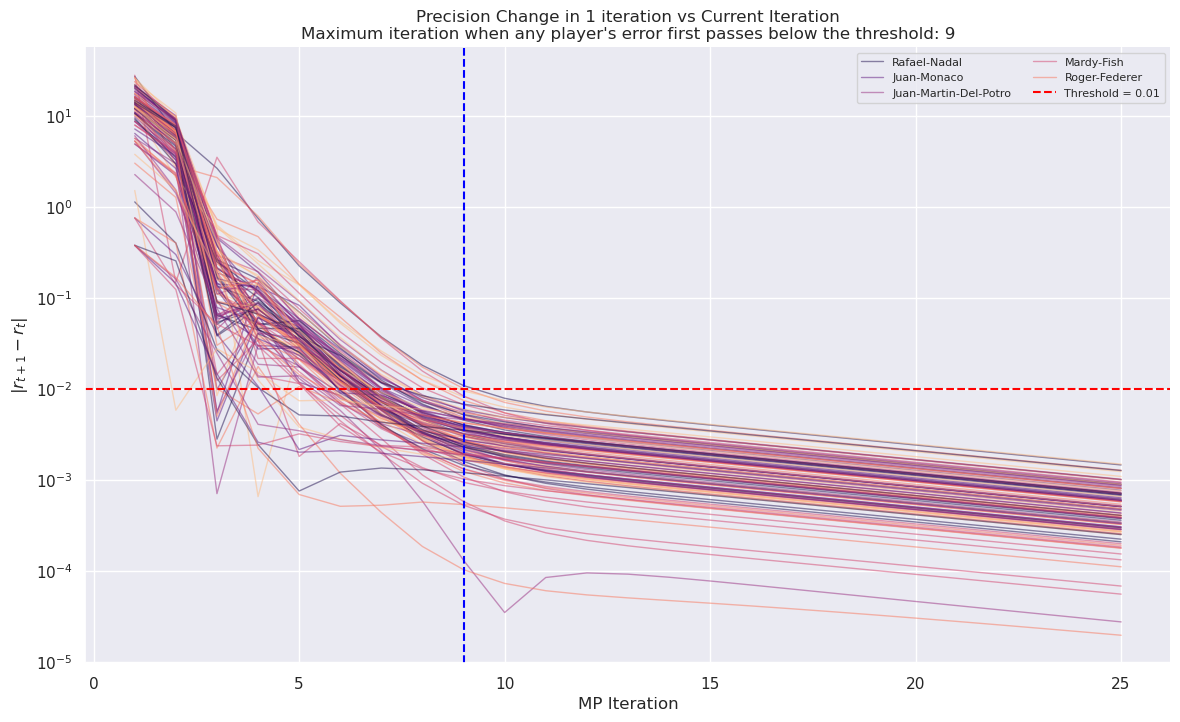

In [100]:
show_n_iter = 25
threshold = 0.01

# Compute the errors between consecutive iterations
errors = np.abs(precision_skills[1:] - precision_skills[:-1])  # Shape: (iterations-1, players)

# Find the iteration when each player's error first goes below the threshold
first_below_threshold = np.argmax(errors < threshold, axis=0)  # Returns the first "True" index for each player

# Mask players who never drop below the threshold within the given iterations
first_below_threshold[~np.any(errors < threshold, axis=0)] = -1  # Set to -1 if never below threshold

# Get the maximum iteration across all players where the threshold is first passed
max_time_below_threshold = np.max(first_below_threshold[first_below_threshold >= 0])

# Plot the errors for the first `show_n_iter` iterations
plt.figure(figsize=(14, 8))
for player_id in range(errors.shape[1]):
    plt.plot(
        np.arange(1, show_n_iter + 1), 
        errors[:show_n_iter, player_id], 
        alpha=0.5, linewidth=1.0, label= W[player_id][0] if player_id < 5 else None
    )
    
# Add threshold line
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold = 0.01")

# Plot enhancements
plt.title("Precision Change in 1 iteration vs Current Iteration\n"
          +
          f"Maximum iteration when any player's error first passes below the threshold: {max_time_below_threshold}"
         )
plt.ylabel("$ |r_{t+1} - r_t| $")
plt.xlabel("MP Iteration")
# Add vertical line for the maximum iteration
plt.axvline(x=max_time_below_threshold, color="blue", linestyle="--")
plt.yscale("log")
plt.legend(loc="upper right", ncol=2, fontsize=8)
plt.savefig("step_change_prec.png")
plt.show()


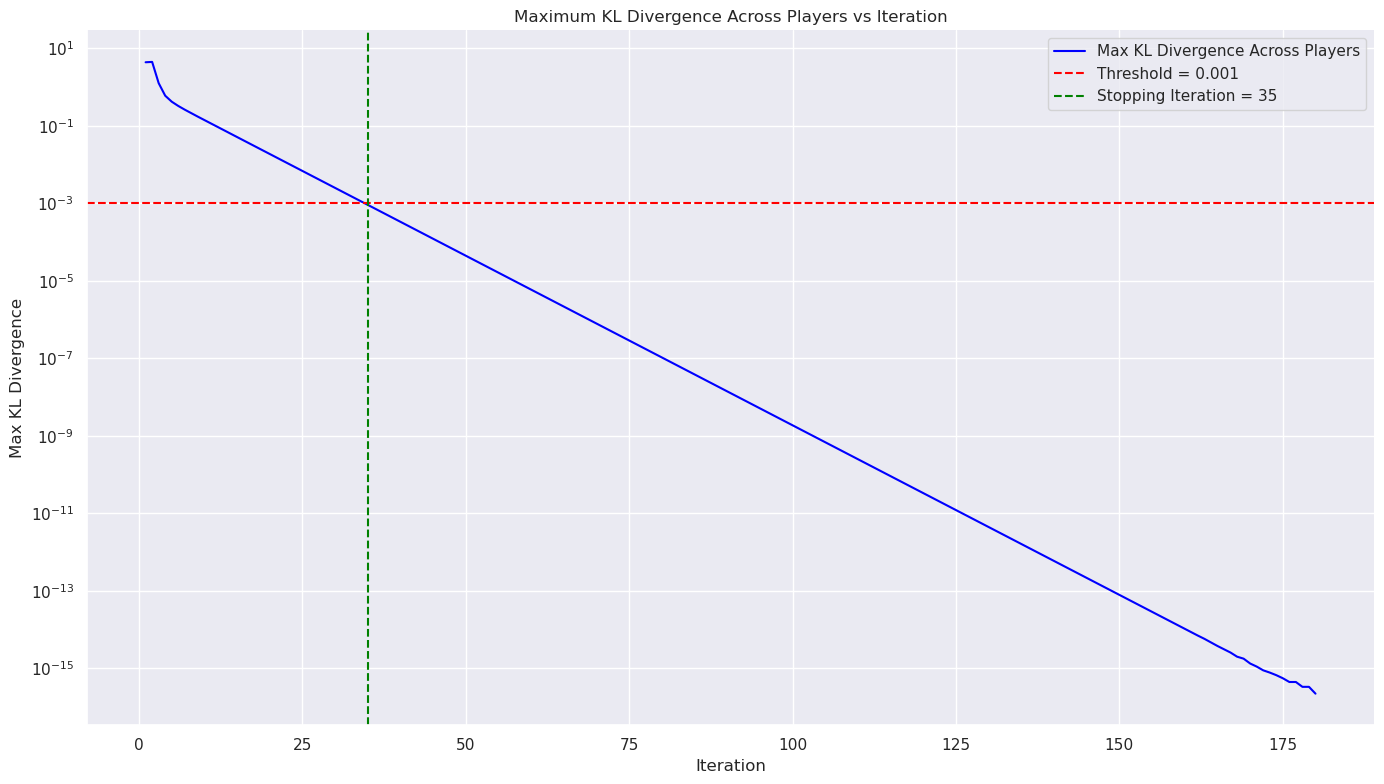

The process should stop at iteration 35 where the max KL divergence falls below the threshold.


In [102]:

# Inputs
threshold = 1E-3
num_iters = mean_skills.shape[0]

# Extract the mean and standard deviation for the initial and current iterations
mu_start = mean_skills[-1]
sigma_start = std_skills[-1]

# Compute KL divergence for each iteration and player
kl_divergences = []
for t in range(num_iters):
    mu_end = mean_skills[t]
    sigma_end = std_skills[t]
    
    kl_div = (
        np.log(sigma_end / sigma_start)
        + (sigma_start**2 + (mu_start - mu_end)**2) / (2 * sigma_end**2)
        - 0.5
    )
    kl_divergences.append(kl_div)

# Convert to array for easy manipulation
kl_divergences = np.array(kl_divergences)  # Shape: (iterations, players)

# Find the maximum KL divergence across players for each iteration
max_kl_per_iter = np.max(kl_divergences, axis=1)

# Find the iteration when the max KL divergence goes below the threshold
stopping_iteration = np.argmax(max_kl_per_iter < threshold) if np.any(max_kl_per_iter < threshold) else -1

# Plot the max KL divergence across iterations
plt.figure(figsize=(14, 8))

plt.plot(
    range(1, 180 + 1),
    max_kl_per_iter[:180],
    label="Max KL Divergence Across Players",
    color="blue"
)
plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
if stopping_iteration != -1:
    plt.axvline(x=stopping_iteration + 1, color="green", linestyle="--", label=f"Stopping Iteration = {stopping_iteration + 1}")

# Plot enhancements
plt.title("Maximum KL Divergence Across Players vs Iteration")
plt.ylabel("Max KL Divergence")
plt.xlabel("Iteration")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("task_b_kl_div.png")
plt.show()

# Output results
if stopping_iteration != -1:
    print(f"The process should stop at iteration {stopping_iteration + 1} where the max KL divergence falls below the threshold.")
else:
    print("The maximum KL divergence never falls below the threshold.")



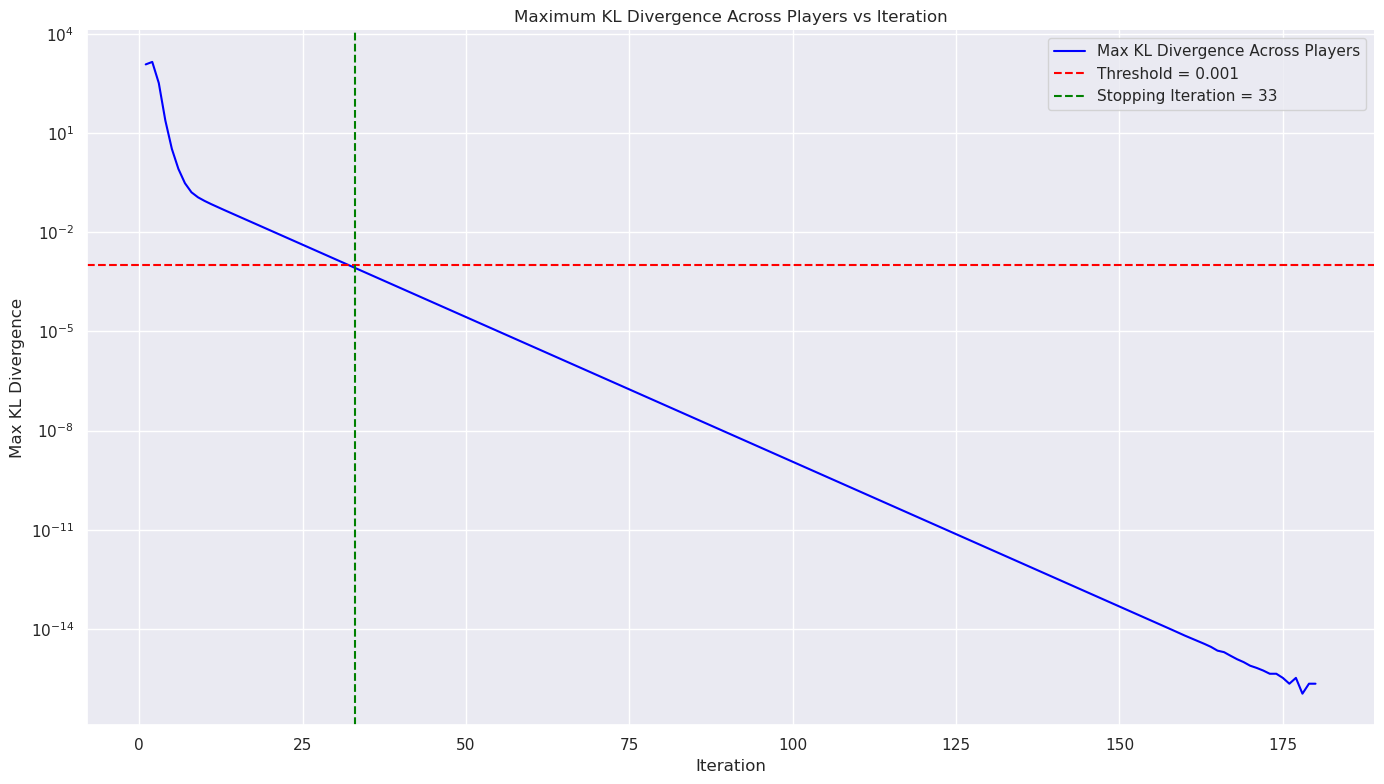

The process should stop at iteration 33 where the max KL divergence falls below the threshold.


In [103]:

# Inputs
threshold = 1E-3
num_iters = precision_skills.shape[0]

# Extract the mean and standard deviation for the initial and current iterations
mu_start = precision_skills[-1]
sigma_start = std_skills[-1]

# Compute KL divergence for each iteration and player
kl_divergences = []
for t in range(num_iters):
    mu_end = precision_skills[t]
    sigma_end = std_skills[t]
    
    kl_div = (
        np.log(sigma_end / sigma_start)
        + (sigma_start**2 + (mu_start - mu_end)**2) / (2 * sigma_end**2)
        - 0.5
    )
    kl_divergences.append(kl_div)

# Convert to array for easy manipulation
kl_divergences = np.array(kl_divergences)  # Shape: (iterations, players)

# Find the maximum KL divergence across players for each iteration
max_kl_per_iter = np.max(kl_divergences, axis=1)

# Find the iteration when the max KL divergence goes below the threshold
stopping_iteration = np.argmax(max_kl_per_iter < threshold) if np.any(max_kl_per_iter < threshold) else -1

# Plot the max KL divergence across iterations
plt.figure(figsize=(14, 8))

plt.plot(
    range(1, 180 + 1),
    max_kl_per_iter[:180],
    label="Max KL Divergence Across Players",
    color="blue"
)
plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
if stopping_iteration != -1:
    plt.axvline(x=stopping_iteration + 1, color="green", linestyle="--", label=f"Stopping Iteration = {stopping_iteration + 1}")

# Plot enhancements
plt.title("Maximum KL Divergence Across Players vs Iteration")
plt.ylabel("Max KL Divergence")
plt.xlabel("Iteration")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("task_b_kl_div_prec.png")
plt.show()

# Output results
if stopping_iteration != -1:
    print(f"The process should stop at iteration {stopping_iteration + 1} where the max KL divergence falls below the threshold.")
else:
    print("The maximum KL divergence never falls below the threshold.")



# Task C

In [113]:
import scipy

In [107]:
# Get top 4 players (by ATP) player IDs
top_4_atp = ['Novak-Djokovic', 'Rafael-Nadal', 'Roger-Federer', 'Andy-Murray']
top_4_atp_ids = []
for name in top_4_atp:
    top_4_atp_ids.append(int(np.argwhere(W[:, 0] == name)))
for player, pid in zip(top_4_atp, top_4_atp_ids):
    print(f"{player} : {pid}")
top_4_atp_ids = np.array(top_4_atp_ids)

Novak-Djokovic : 15
Rafael-Nadal : 0
Roger-Federer : 4
Andy-Murray : 10


/tmp/ipykernel_294626/3894640541.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  top_4_atp_ids.append(int(np.argwhere(W[:, 0] == name)))


In [108]:
top_4_means = mean_player_skills[top_4_atp_ids]
top_4_vars = precision_player_skills[top_4_atp_ids]**(-1)
mean_differences = top_4_means[:, None] -  top_4_means[None,:]
vars_sums = top_4_vars[:, None] +  top_4_vars[None,:]

In [111]:
print(mean_differences,"\n\n")
print(vars_sums)

[[ 0.          0.41379688  0.36626177  0.60431027]
 [-0.41379688  0.         -0.04753511  0.19051338]
 [-0.36626177  0.04753511  0.          0.2380485 ]
 [-0.60431027 -0.19051338 -0.2380485   0.        ]] 


[[0.07931662 0.07096981 0.07539152 0.07693808]
 [0.07096981 0.062623   0.06704471 0.06859127]
 [0.07539152 0.06704471 0.07146641 0.07301297]
 [0.07693808 0.06859127 0.07301297 0.07455954]]


Finding the probability of having better skill

In [114]:
prob_has_better_skill = 1.0 - scipy.stats.norm.cdf(0, mean_differences, vars_sums**0.5)
print(prob_has_better_skill)

[[0.5        0.93982214 0.90888525 0.9853215 ]
 [0.06017786 0.5        0.42717033 0.76651864]
 [0.09111475 0.57282967 0.5        0.81083534]
 [0.0146785  0.23348136 0.18916466 0.5       ]]


Finding the win probability

In [115]:
prob_win = 1.0 - scipy.stats.norm.cdf(0, mean_differences, (vars_sums + 1.0)**0.5)
print(prob_win)

[[0.5        0.65536701 0.63802696 0.71982573]
 [0.34463299 0.5        0.48164814 0.57311   ]
 [0.36197304 0.51835186 0.5        0.59087907]
 [0.28017427 0.42689    0.40912093 0.5       ]]


# Task D
For the Gibbs sampler, compare the skills of Nadal and Federer.

In [116]:
thin_factor = 10
burn_factor = 150
# number of iterations
num_samples_to_generate = 100
num_iters = burn_factor + num_samples_to_generate * thin_factor
# perform gibbs sampling, skill samples is an num_players x num_samples array
np.random.seed(0)
iid_samples = gibbs_sample(G, M, num_iters)[:, burn_factor::thin_factor]

100%|██████████████████████████████████| 1150/1150 [00:16<00:00, 69.35it/s]


### 1) based on approximating their marginal skills by Gaussians

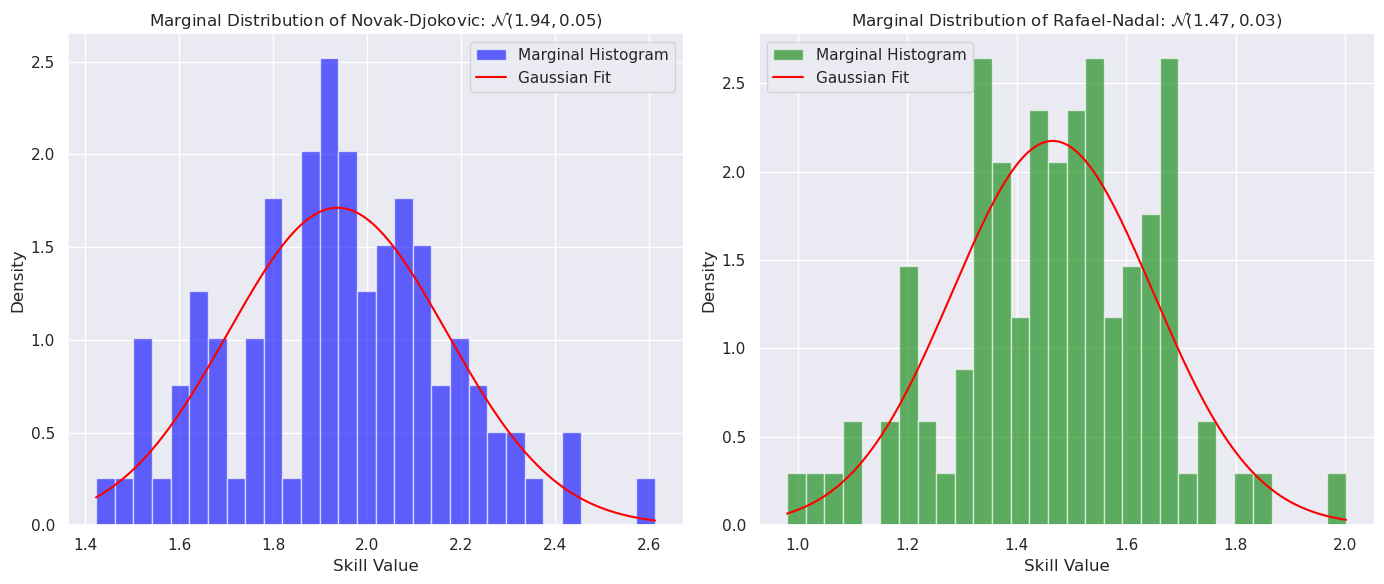

In [163]:
from scipy.stats import norm

# Assuming `skill_samples_df` contains your data
x = skill_samples_df[top_4_atp[0]]
y = skill_samples_df[top_4_atp[1]]

# Fit 1D Gaussians to the marginals
meanx, meany = x.mean(), y.mean()
stdx, stdy = np.std(x), np.std(y)

# Create a grid for plotting the PDFs
x_grid = np.linspace(x.min(), x.max(), 500)
y_grid = np.linspace(y.min(), y.max(), 500)

# Compute the PDF of the 1D Gaussians
p_x = norm.pdf(x_grid, loc=meanx, scale=stdx)
p_y = norm.pdf(y_grid, loc=meany, scale=stdy)

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the data and fitted Gaussian for x
ax[0].hist(x, bins=30, density=True, alpha=0.6, color='blue', label="Marginal Histogram")
ax[0].plot(x_grid, p_x, color='red', label="Gaussian Fit")
ax[0].set_title(rf"Marginal Distribution of {top_4_atp[0]}: $\mathcal{{N}}({meanx:.2f}, {stdx**2:.2f})$")
ax[0].set_xlabel("Skill Value")
ax[0].set_ylabel("Density")
ax[0].legend()

# Plot the data and fitted Gaussian for y
ax[1].hist(y, bins=30, density=True, alpha=0.6, color='green', label="Marginal Histogram")
ax[1].plot(y_grid, p_y, color='red', label="Gaussian Fit")
ax[1].set_title(rf"Marginal Distribution of {top_4_atp[1]}: $\mathcal{{N}}({meany:.2f}, {stdy**2:.2f})$")
ax[1].set_xlabel("Skill Value")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.savefig("task_d_marginal_gauss_with_reg")
plt.show()

In [184]:
# Probability Djokovic's skill is higher
prob_skill_higher = 1.0 - scipy.stats.norm.cdf(0, meanx - meany, (stdx**2 + stdy**2)**0.5)
print(f"Probability Djokovic's skill is higher: {round(100 * prob_skill_higher, 2)}%")

Probability Djokovic's skill is higher: 94.38%


### 2) based on approximating their joint skills by a Gaussian

<Figure size 1400x1400 with 0 Axes>

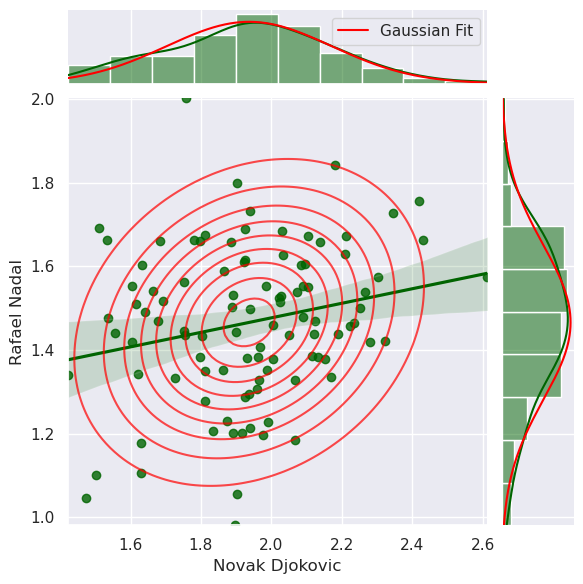

In [194]:
from scipy.stats import multivariate_normal
plt.figure(figsize=(14, 14))
# Assuming `skill_samples_df` contains your data
x = skill_samples_df[top_4_atp[0]]
y = skill_samples_df[top_4_atp[1]]

# Fit a 2D Gaussian
mean = [x.mean(), y.mean()]
cov = np.cov(x, y)

# Create a grid for the contour plot
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
pos = np.dstack((xx, yy))

# Compute the PDF of the 2D Gaussian
rv = multivariate_normal(mean, cov)
pdf = rv.pdf(pos)

# Create the jointplot with regression
g = sns.jointplot(x=x, y=y, kind="reg", color="darkgreen")

# Overlay the Gaussian contour
g.ax_joint.contour(xx, yy, pdf, levels=10, colors="red", alpha=0.7,)
# Fit 1D Gaussians for the marginals
mean_x, std_x = x.mean(), x.std()
mean_y, std_y = y.mean(), y.std()

x_grid = np.linspace(x.min(), x.max(), 500)
y_grid = np.linspace(y.min(), y.max(), 500)

p_x = norm.pdf(x_grid, loc=mean_x, scale=std_x)
p_y = norm.pdf(y_grid, loc=mean_y, scale=std_y)

scale = (x.max() - x.min()) * x.size /10
# Plot the marginal histograms with Gaussian fits
g.ax_marg_x.plot(x_grid, p_x * scale  , color="red", label="Gaussian Fit")
g.ax_marg_x.legend()
scale = (y.max() - y.min()) * y.size /10
g.ax_marg_y.plot(p_y * scale, y_grid, color="red")


# Add labels and save the figure
g.ax_joint.set_xlabel("Novak Djokovic")
g.ax_joint.set_ylabel("Rafael Nadal")
plt.savefig("joint_gaussian_with_reg.png", format="png", dpi=200, bbox_inches="tight")
plt.show()


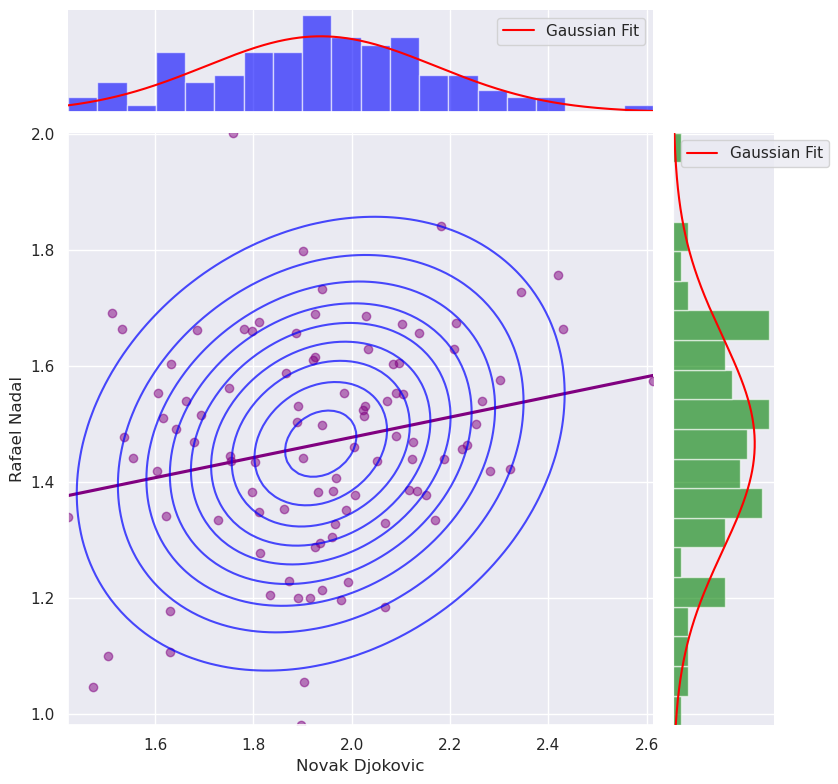

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import seaborn as sns

# Assuming `skill_samples_df` contains your data
x = skill_samples_df[top_4_atp[0]]
y = skill_samples_df[top_4_atp[1]]

# Fit a 2D Gaussian
mean = [x.mean(), y.mean()]
cov = np.cov(x, y)

# Create a grid for the contour plot
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
pos = np.dstack((xx, yy))

# Compute the PDF of the 2D Gaussian
rv = multivariate_normal(mean, cov)
pdf = rv.pdf(pos)

# Fit 1D Gaussians for the marginals
mean_x, std_x = x.mean(), x.std()
mean_y, std_y = y.mean(), y.std()

x_grid = np.linspace(x.min(), x.max(), 500)
y_grid = np.linspace(y.min(), y.max(), 500)

p_x = norm.pdf(x_grid, loc=mean_x, scale=std_x)
p_y = norm.pdf(y_grid, loc=mean_y, scale=std_y)

# Create a custom JointGrid for better control over the layout
g = sns.JointGrid(x=x, y=y, space=0.2, height=8)

# Plot the joint scatter with regression line
g.ax_joint.scatter(x, y, alpha=0.5, color="purple")
sns.regplot(x=x, y=y, scatter=False, ax=g.ax_joint, color="purple", ci=None)

# Plot the 2D Gaussian contour on the joint plot
g.ax_joint.contour(xx, yy, pdf, levels=10, colors="blue", alpha=0.7)

# Plot the marginal histograms with Gaussian fits
g.ax_marg_x.hist(x, bins=20, density=True, alpha=0.6, color="blue")
g.ax_marg_x.plot(x_grid, p_x, color="red", label="Gaussian Fit")
g.ax_marg_x.legend()

g.ax_marg_y.hist(y, bins=20, density=True, alpha=0.6, color="green", orientation="horizontal")
g.ax_marg_y.plot(p_y, y_grid, color="red", label="Gaussian Fit")
g.ax_marg_y.legend()

# Label the axes and show the plot
g.ax_joint.set_xlabel("Novak Djokovic")
g.ax_joint.set_ylabel("Rafael Nadal")
plt.savefig("joint_gaussian_with_marginals.png", format="png", dpi=200, bbox_inches="tight")
plt.show()

In [157]:
print(f"Joint Gaussian best fit approximator:")
print(f"Mean:\n{np.round(mean,2)}^T")
print(f"Covariance:\n{np.round(cov,2)}")

Joint Gaussian best fit approximator:
Mean:
[1.94 1.47]^T
Covariance:
[[0.05 0.01]
 [0.01 0.03]]


In [186]:
mc_joint_gaussian_samples = np.random.multivariate_normal(mean, cov, size=1_000_000)
prob_skill_higher = np.mean(mc_joint_gaussian_samples[:, 0] > mc_joint_gaussian_samples[:, 1])
print(f"Probability Djokovic's skill is higher: {round(100 * prob_skill_higher, 2)}%")

Probability Djokovic's skill is higher: 96.24%


### 3) directly from the samples

In [189]:
prob_skill_higher = np.mean(
    iid_samples[top_4_atp_ids[0], :] > iid_samples[top_4_atp_ids[1], :]
)
print(f"Probability Djokovic's skill is higher: {round(100 * prob_skill_higher, 2)}%")

Probability Djokovic's skill is higher: 97.0%


#### Calculate the probability that a player has a better skill than another in top 4.

In [195]:
prob_higher_skill = np.zeros([4, 4])

for i in range(4):
    for j in range(4):
        player1 = top_4_atp_ids[i]
        player2 = top_4_atp_ids[j]
        prob_higher_skill[i, j] = np.mean(iid_samples[player1, :] > iid_samples[player2, :])

print(prob_higher_skill)

[[0.   0.97 0.96 0.99]
 [0.03 0.   0.37 0.72]
 [0.04 0.63 0.   0.81]
 [0.01 0.28 0.19 0.  ]]


# Task E

In [197]:
skill_mean_gibbs = np.mean(iid_samples, axis=1)
skill_std_gibbs = np.std(iid_samples, axis=1)
skill_mean_mp = mean_player_skills
skill_std_mp = (1 / precision_player_skills)**0.5

In [198]:
### Empirical Estimate

In [199]:
frac_games_won = np.zeros(M)
for player_id in range(M):
    frac_games_won[player_id] = np.sum(G[:, 0] == player_id) / np.sum(G == player_id)

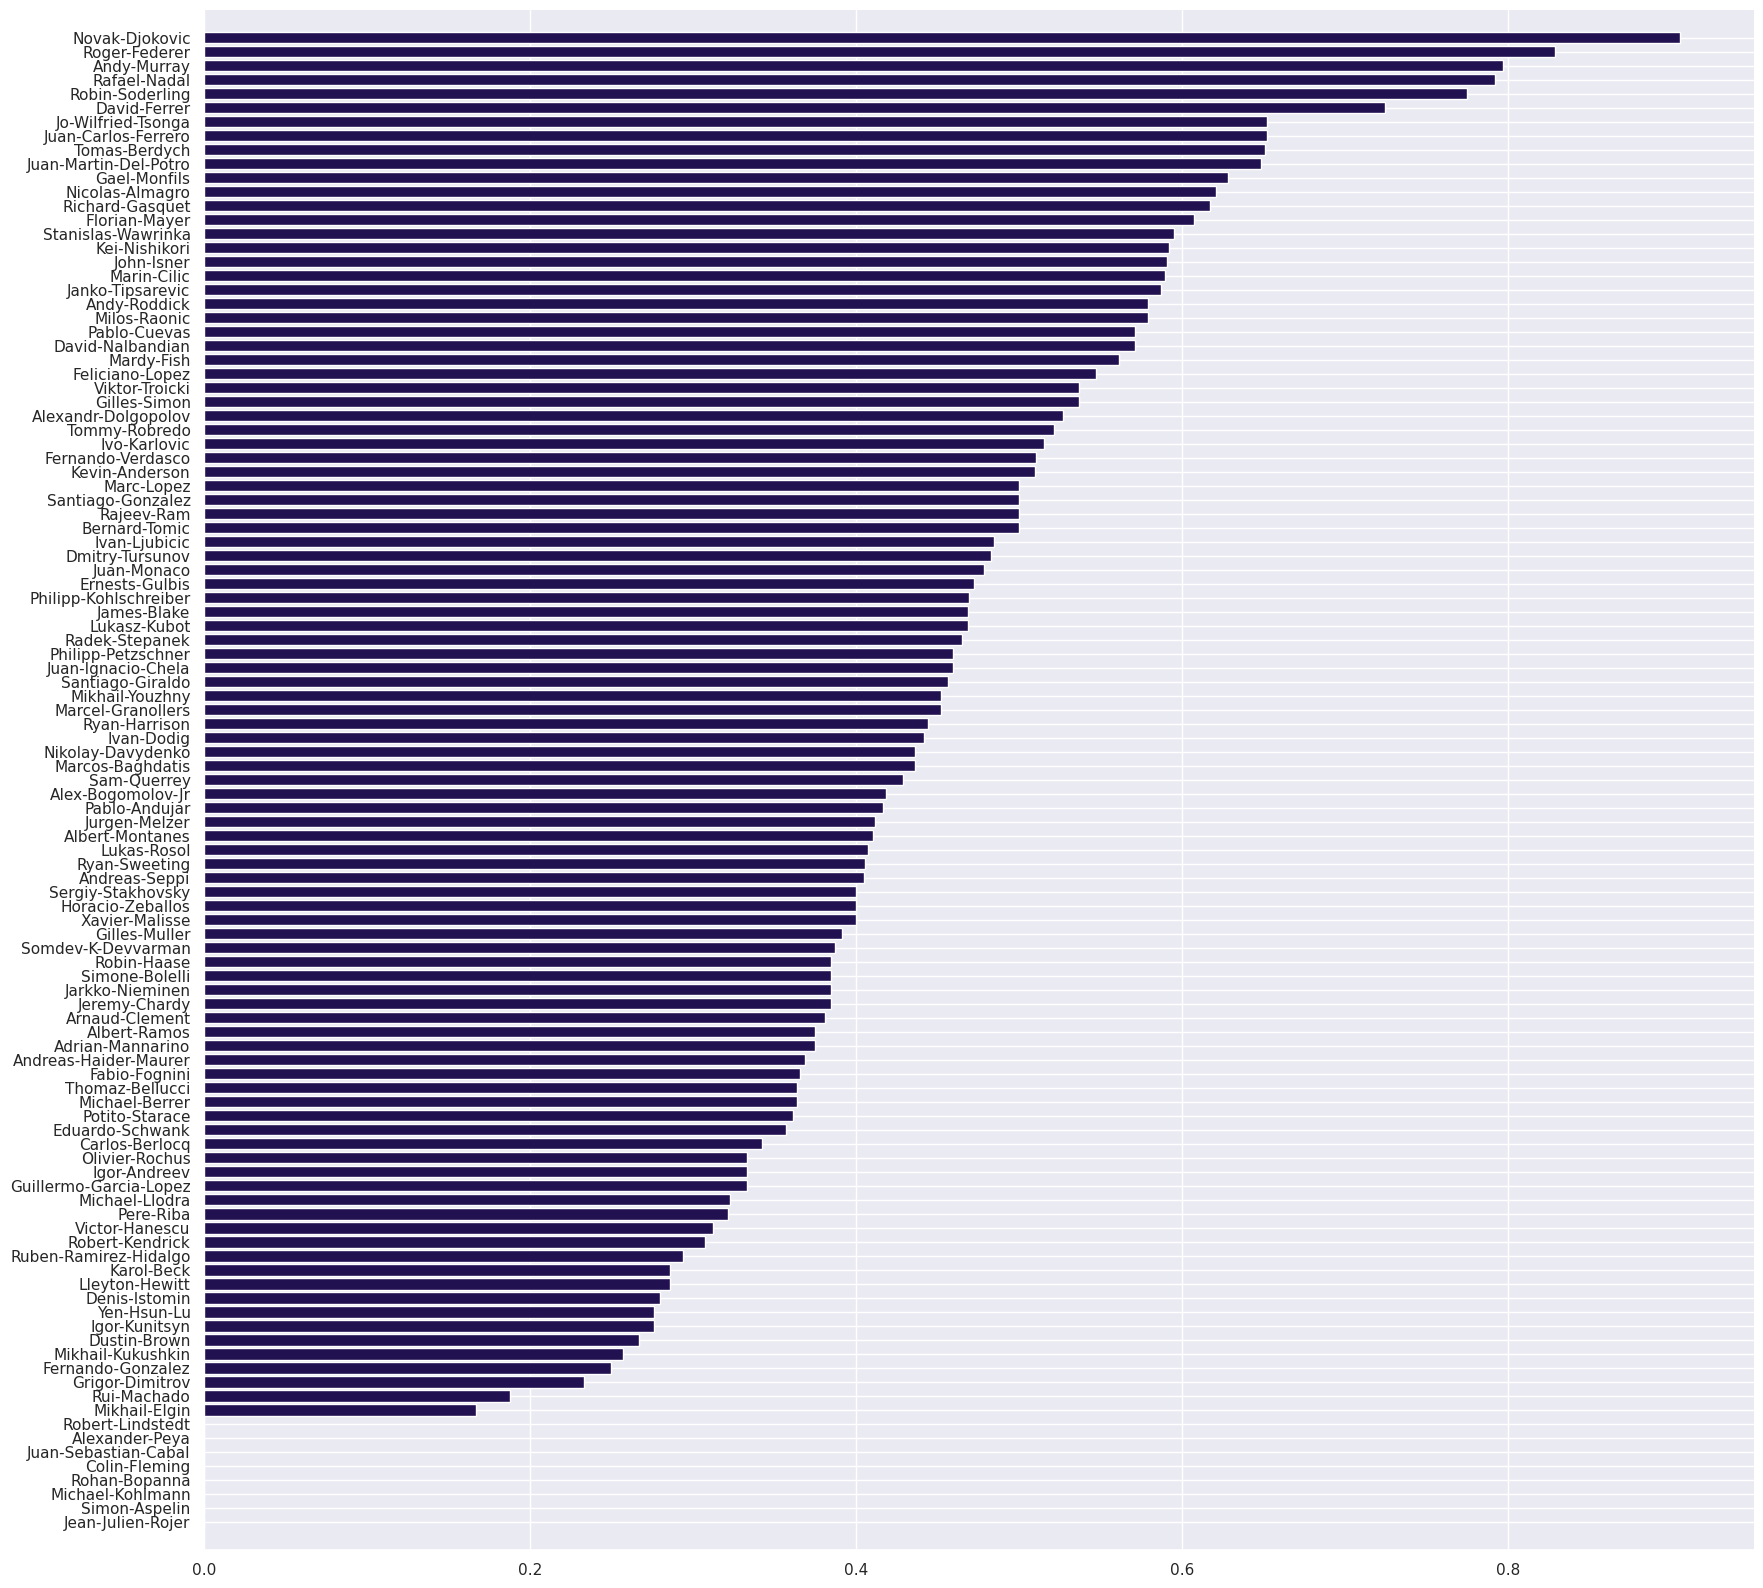

<Figure size 640x480 with 0 Axes>

In [209]:
fig = sorted_barplot(frac_games_won, W)
plt.savefig("task_e_empirical.png")

## Gibbs Probabilistic Ranking

In [202]:
s = iid_samples[:, None, :] - iid_samples[None, :, :] # implements s_ij = w_i - w_j by vectorizing along the player axis
t = s + np.random.randn(s.shape[2])
p_win = np.mean(t > 0, axis=2)
avg_prob_win_gibbs = np.zeros(M)
for i in range(M):
    for j in range(M):
        if i != j:
            avg_prob_win_gibbs[i] += p_win[i, j]
avg_prob_win_gibbs /= (M-1)
print(avg_prob_win_gibbs)

[0.87698113 0.54292453 0.69962264 0.63603774 0.9        0.74216981
 0.33877358 0.62518868 0.57584906 0.45169811 0.84018868 0.65490566
 0.58773585 0.42688679 0.64301887 0.95349057 0.55707547 0.48188679
 0.38349057 0.54867925 0.60207547 0.41122642 0.55641509 0.78037736
 0.61481132 0.62283019 0.48509434 0.38556604 0.65066038 0.78566038
 0.42783019 0.57037736 0.54509434 0.7240566  0.40877358 0.55216981
 0.33650943 0.53622642 0.2940566  0.45622642 0.49424528 0.56943396
 0.61433962 0.38       0.62584906 0.50075472 0.61698113 0.62292453
 0.38320755 0.4145283  0.35320755 0.25141509 0.48009434 0.30603774
 0.41707547 0.34877358 0.37584906 0.53377358 0.30358491 0.40349057
 0.39981132 0.48056604 0.53264151 0.43707547 0.49783019 0.48556604
 0.2909434  0.31122642 0.4854717  0.50179245 0.31490566 0.45169811
 0.35037736 0.37669811 0.22424528 0.43358491 0.42216981 0.32037736
 0.44726415 0.56556604 0.31198113 0.44066038 0.315      0.395
 0.31273585 0.275      0.44830189 0.31179245 0.25150943 0.41509434


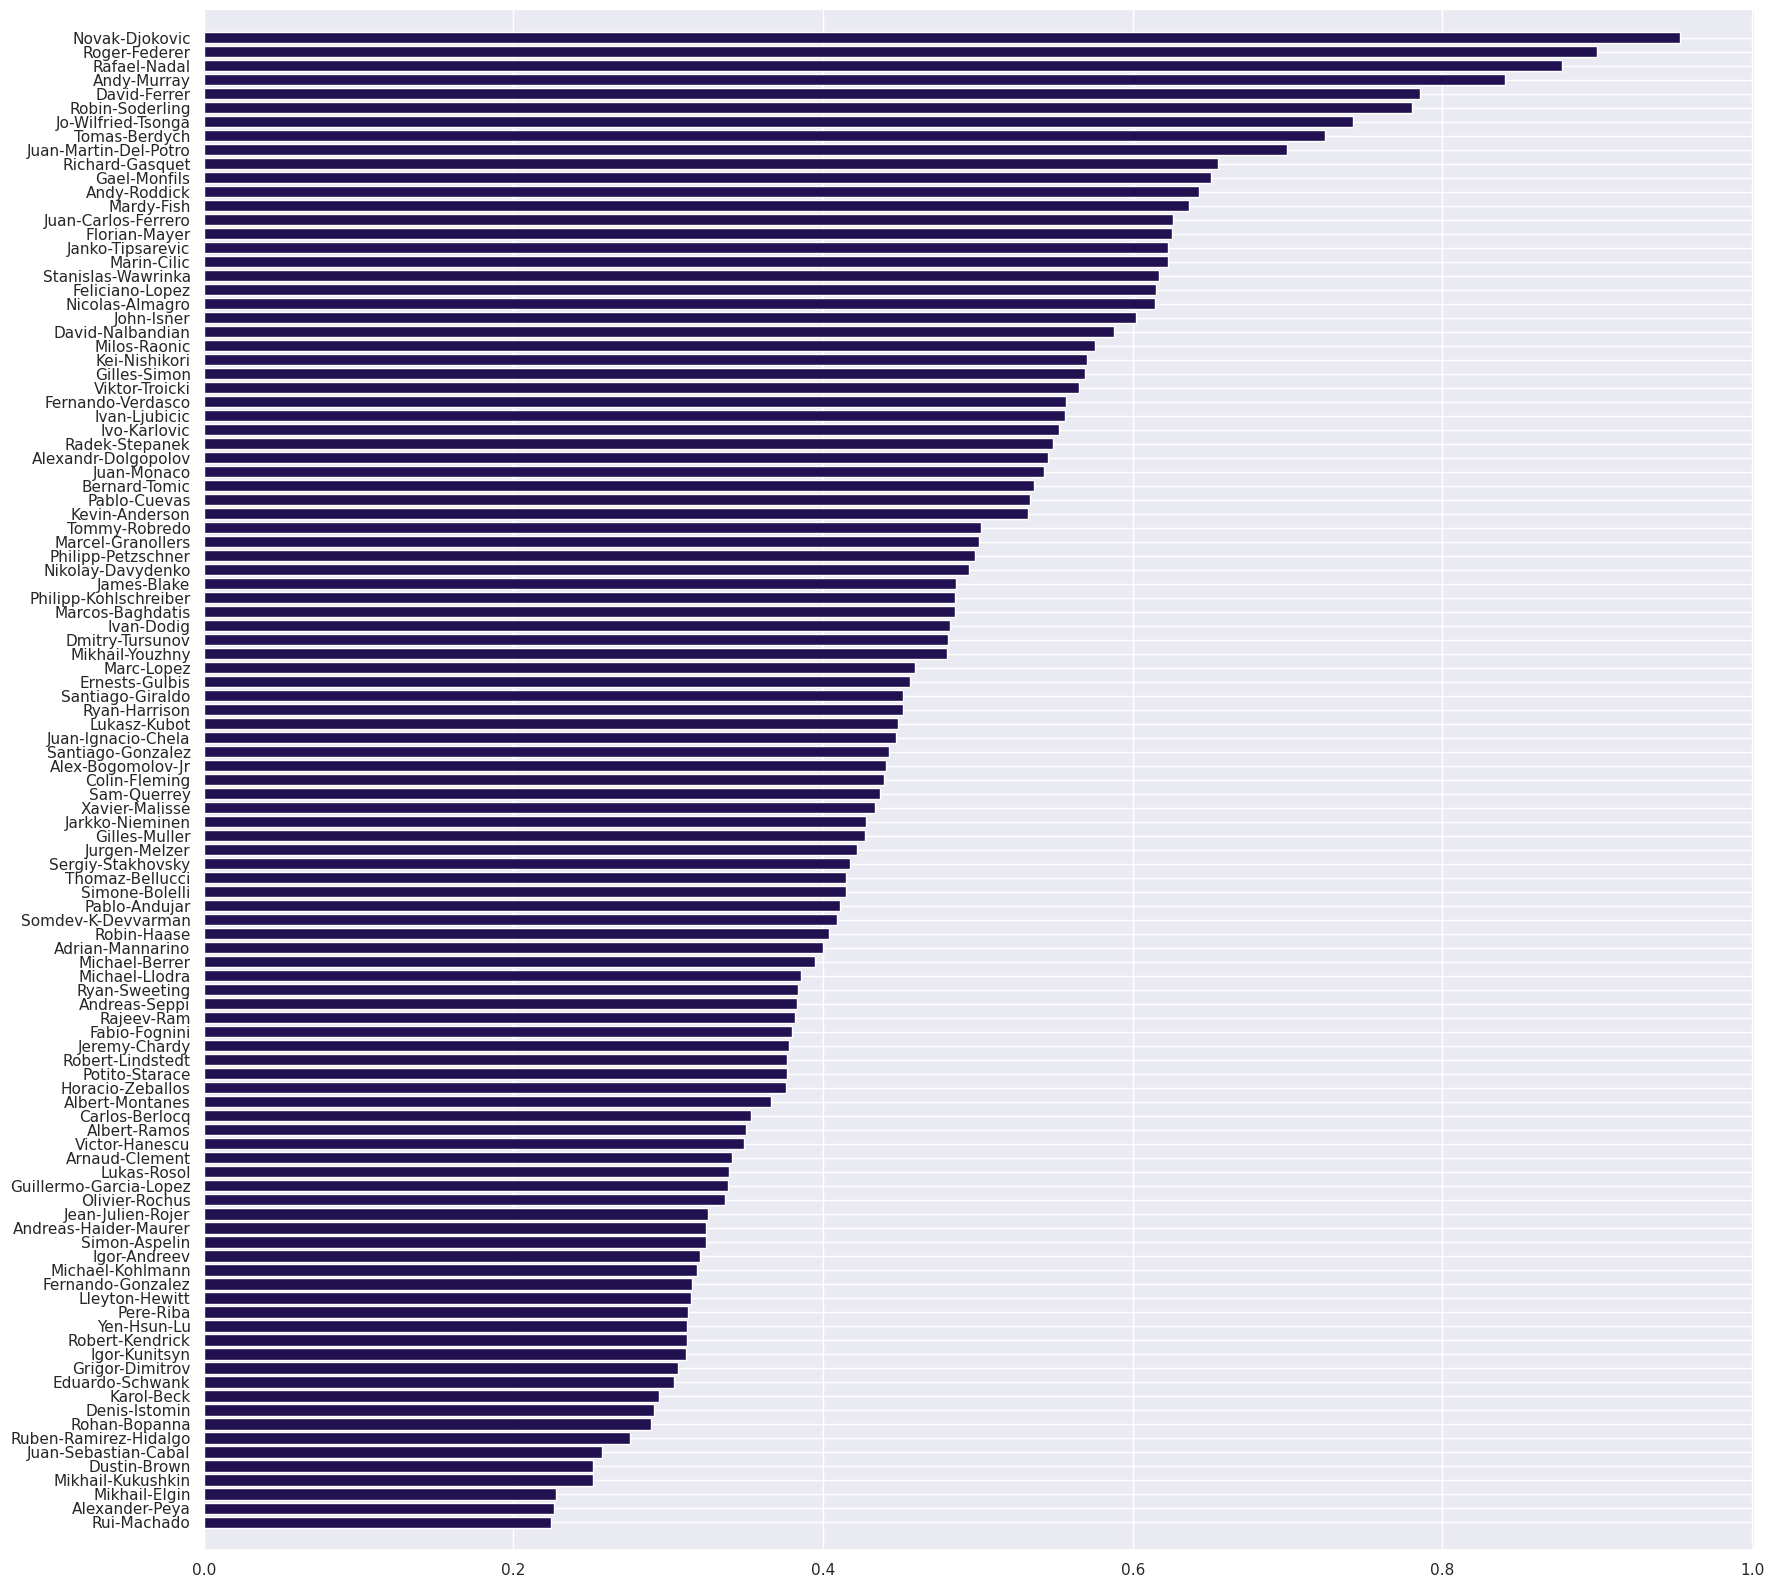

<Figure size 640x480 with 0 Axes>

In [210]:
fig = sorted_barplot(avg_prob_win_gibbs, W)
plt.savefig("task_e_gibbs.png")

## MP Probabilistic Ranking

In [206]:
mean_differences = skill_mean_mp[:, None] -  skill_mean_mp[None,:] # Implements s_i,j = mu_i - mu_j
std_sums = ( 1.0 + skill_std_mp[:, None]**2 +  skill_std_mp[None,:]**2 )**0.5 # Implements Var_ij = std^2_i + std^2_j

In [207]:
prob_win_mp = 1.0 - scipy.stats.norm.cdf(0, mean_differences, std_sums)
print(prob_win_mp)

[[0.5        0.88314903 0.75589844 ... 0.98418695 0.92603128 0.95487029]
 [0.11685097 0.5        0.30909791 ... 0.85035262 0.66247779 0.74502558]
 [0.24410156 0.69090209 0.5        ... 0.93365439 0.80222604 0.86269825]
 ...
 [0.01581305 0.14964738 0.06634561 ... 0.5        0.30368765 0.38487647]
 [0.07396872 0.33752221 0.19777396 ... 0.69631235 0.5        0.58358037]
 [0.04512971 0.25497442 0.13730175 ... 0.61512353 0.41641963 0.5       ]]


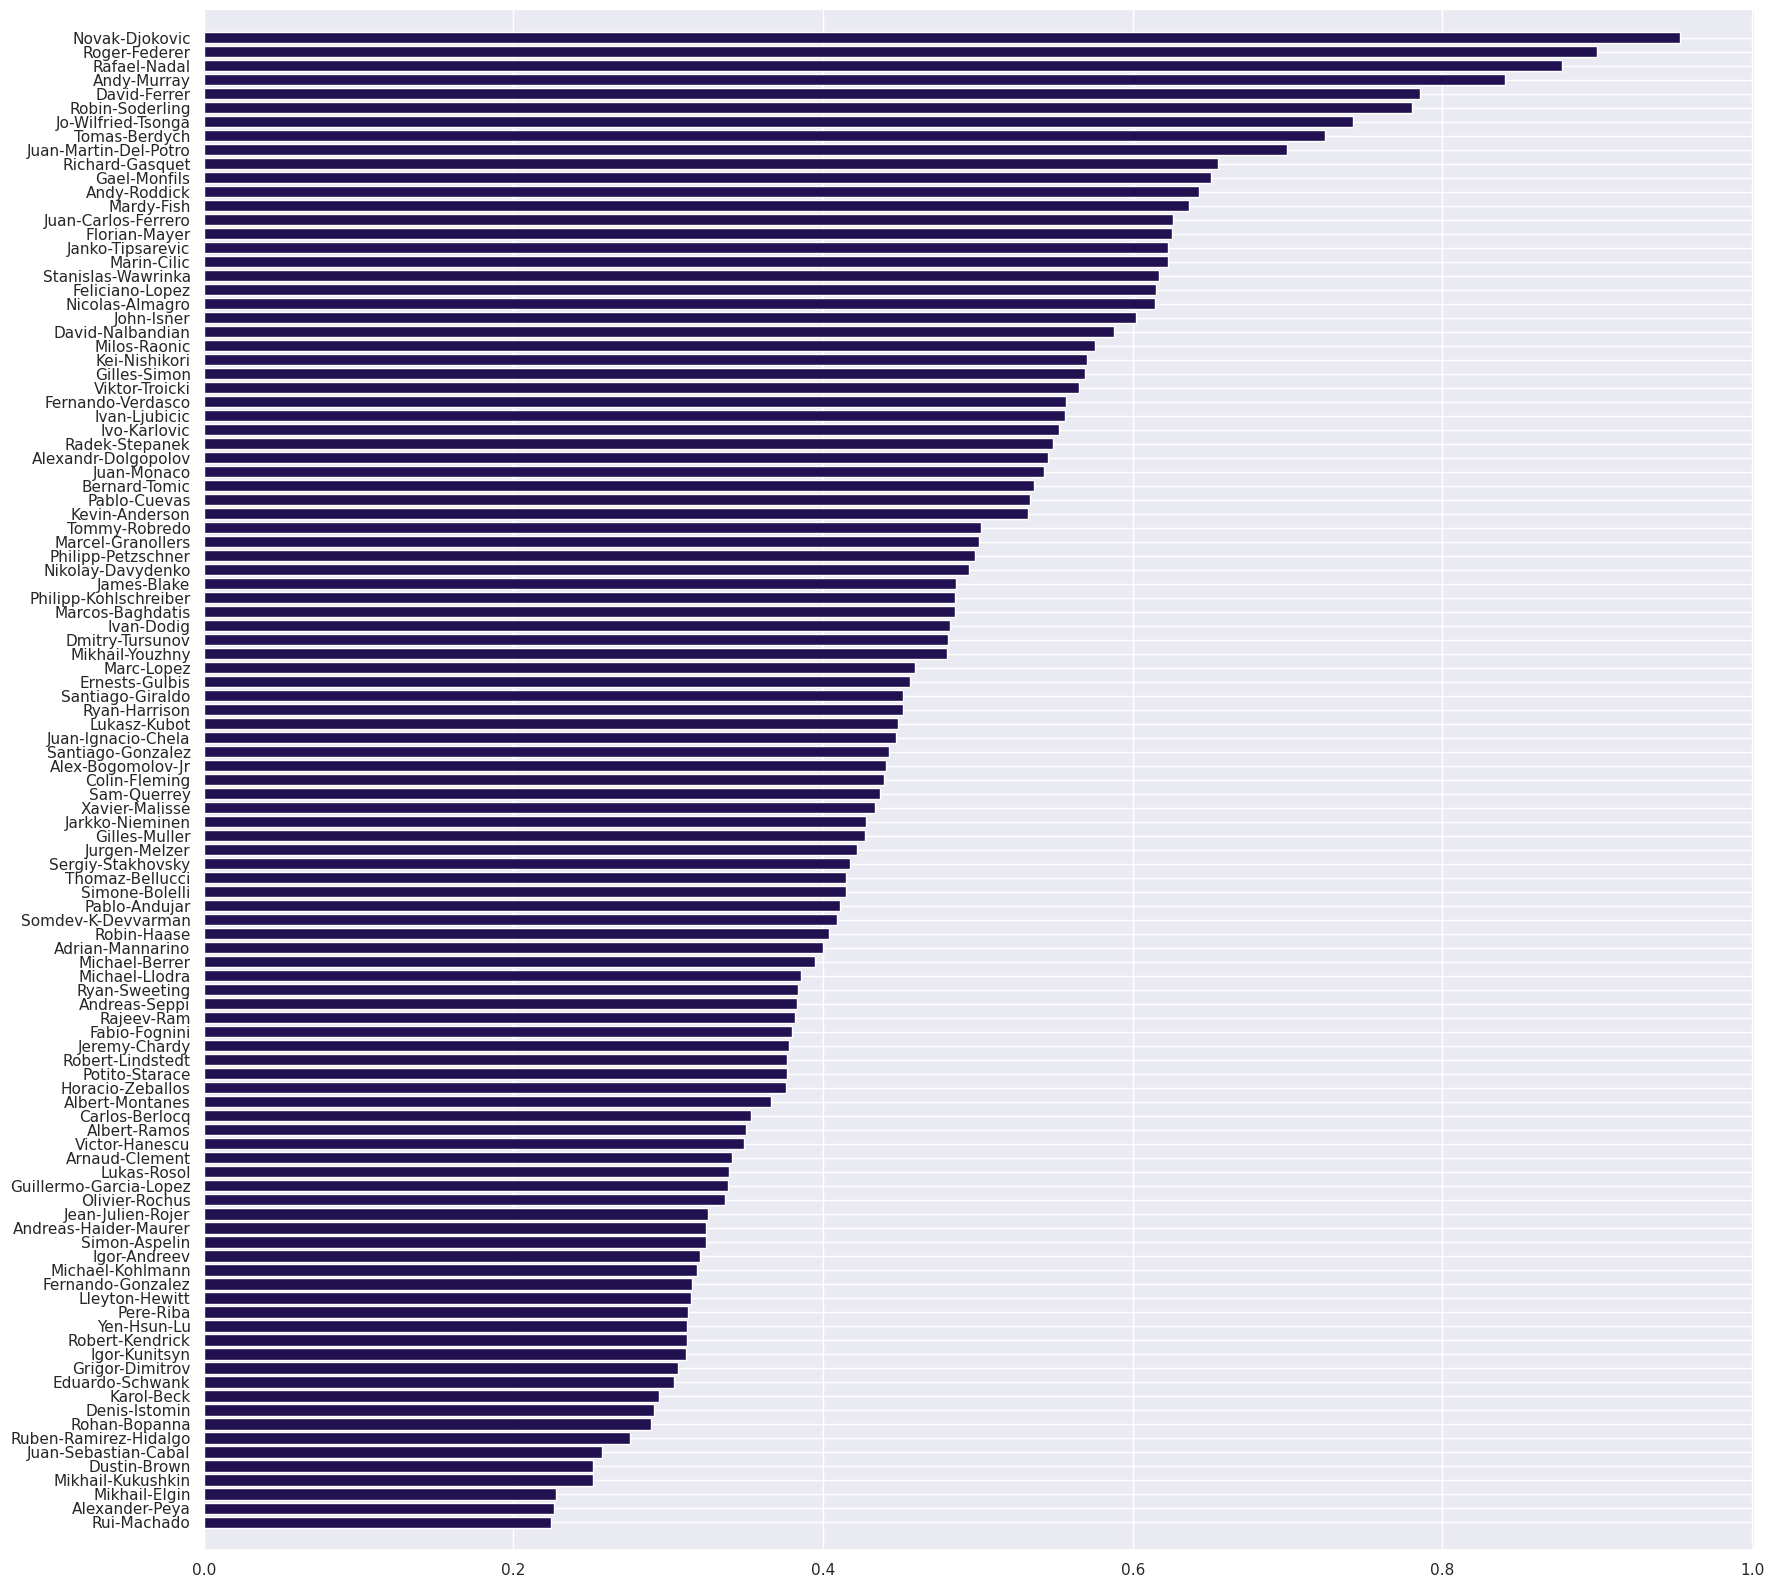

<Figure size 640x480 with 0 Axes>

In [211]:
fig = sorted_barplot(avg_prob_win_gibbs, W)
plt.savefig("task_e_mp.png")